# Initialization
using Python 3.11.9, Tensorflow 2.17, Keras 3.5, tf-keras 3.5, keras-core-0.1.7 keras-cv-0.9.0 keras-hub-0.17.0 keras-nlp-0.17.0

In [1]:
!pip install --upgrade pip
!pip uninstall tensorflow keras tf-keras
!pip install tensorflow==2.17 keras==3.5 tf-keras==2.17 keras-cv keras-nlp pandas numpy matplotlib seaborn scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 30.9 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
Found existing installation: tensorflow 2.17.0
Uninstalling tensorflow-2.17.0:
  Would remove:
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.10/dist-packages/tensorflow-2.17.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/tensorflow/*
Proceed (Y/n)? 
  Successfully uninstalled tensorflow-2.17.0
Found existing installation: keras 3.4.1
Uninstalling keras-3.4.1:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/keras-3.4.1.dist-info/*
    /usr/local/lib/python3.10/dist-packages/keras/*
Proceed (Y/n)? y
  Successfully uninstalled keras-3.4

In [2]:
import time
import numpy as np
import pandas as pd
from itertools import cycle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_fscore_support
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from keras_core.models import Sequential
from keras_core.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, Bidirectional, LSTM, MaxPooling1D, Input
from keras_core.preprocessing.sequence import pad_sequences
from keras_core.utils import to_categorical
from keras_core.callbacks import EarlyStopping

Using TensorFlow backend


# Define global functions

In [3]:
# Convert sequences back to text for Naive Bayes
def sequences_to_texts(sequences, word_index):
    reverse_word_index = {v: k for k, v in word_index.items()}
    return [' '.join([reverse_word_index.get(i, '') for i in sequence]) for sequence in sequences]

# Define helper functions for metrics and visualization
def print_metrics(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    print(f"\nMetrics for {model_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Add class-wise metrics
    class_precision = precision_score(y_true, y_pred, average=None, zero_division=0)
    class_recall = recall_score(y_true, y_pred, average=None, zero_division=0)
    class_f1 = f1_score(y_true, y_pred, average=None, zero_division=0)

    print("\nClass-wise metrics:")
    for i, (p, r, f) in enumerate(zip(class_precision, class_recall, class_f1)):
        print(f"Class {i}: Precision: {p:.4f}, Recall: {r:.4f}, F1: {f:.4f}")

    # Print confusion matrix
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_true, y_pred)
    print(cm)

def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    # Add class distribution information
    class_distribution = np.sum(cm, axis=1)
    plt.text(1.5, -0.5, f"Class Distribution: {class_distribution}", fontsize=10, ha='right', va='center')

    plt.show()

def plot_roc_curve(y_true, y_pred, model_name, class_labels=['Negative', 'Neutral', 'Positive']):
    # Binarize the output
    classes = np.unique(y_true)
    y_true_bin = label_binarize(y_true, classes=classes)
    n_classes = y_true_bin.shape[1]

    # Check if y_pred is already probability estimates
    if y_pred.ndim == 1 or y_pred.shape[1] == 1:
        y_pred_bin = label_binarize(y_pred, classes=classes)
        y_score = y_pred_bin
    else:
        y_score = y_pred

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    plt.figure(figsize=(10, 8))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of {class_labels[i]} (area = {roc_auc[i]:0.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

    return fpr, tpr, roc_auc

def plot_training_history(history, model_name):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

def analyze_predictions(y_true, y_pred, model_name):
    print(f"\nAnalysis for {model_name}:")

    # Class distribution in true labels
    unique, counts = np.unique(y_true, return_counts=True)
    print("Class distribution in true labels:")
    for class_label, count in zip(unique, counts):
        print(f"Class {class_label}: {count}")

    # Class distribution in predictions
    unique, counts = np.unique(y_pred, return_counts=True)
    print("\nClass distribution in predictions:")
    for class_label, count in zip(unique, counts):
        print(f"Class {class_label}: {count}")

    # Check for classes not predicted
    true_classes = set(y_true)
    pred_classes = set(y_pred)
    not_predicted = true_classes - pred_classes
    if not_predicted:
        print(f"\nClasses not predicted by the model: {not_predicted}")

def create_train_test_split(X, y, test_size=0.2, random_state=None):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Pad sequences
    max_length = 500  # or whatever your max_length is
    X_train_padded = pad_sequences(X_train, maxlen=max_length)
    X_test_padded = pad_sequences(X_test, maxlen=max_length)

    # Convert labels to categorical
    y_train_cat = to_categorical(y_train)
    y_test_cat = to_categorical(y_test)

    return X_train_padded, X_test_padded, y_train_cat, y_test_cat, y_train, y_test


# Function to load GloVe embeddings
def load_glove_embeddings(word_index, embedding_dim):
    embeddings_index = {}
    with open(f'glove.6B.{embedding_dim}d.txt', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    num_words = min(len(word_index) + 1, 10000)
    embedding_matrix = np.zeros((num_words, embedding_dim))
    for word, i in word_index.items():
        if i >= num_words:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return embedding_matrix


# Load our python library

In [4]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/phd

Mounted at /content/drive
/content/drive/MyDrive/phd


In [5]:
from tp import load_data, get_word_index


# Load the data

In [23]:
# Load the full dataset
X, y = load_data(num_words=10000, maxlen=500)
word_index = get_word_index()

num_words = min(10000, len(word_index) + 1)
print(f"Number of words in word_index: {len(word_index)}")
print(f"Shape of y:{y.shape}")
print(f"Unique classes in y: {np.unique(y)}")
print(f"Example of first few labels: {y[:10]}")
# Calculate the length of each sample, excluding padding (assuming padding token is 0)
sample_lengths = np.array([np.sum(x > 0) for x in X])

# Overall statistics
average_word_count = np.mean(sample_lengths)
median_word_count = np.median(sample_lengths)

print(f"Overall average word count per sample: {average_word_count:.2f}")
print(f"Overall median word count per sample: {median_word_count:.2f}")

# Statistics per class
class_labels = np.unique(y)
for label in class_labels:
    class_sample_lengths = sample_lengths[y == label]
    class_avg = np.mean(class_sample_lengths)
    class_median = np.median(class_sample_lengths)
    print(f"\nClass {label} - Average word count: {class_avg:.2f}")
    print(f"Class {label} - Median word count: {class_median:.2f}")

Number of words in word_index: 64753
Shape of y:(225020,)
Unique classes in y: [0 1 2]
Example of first few labels: [0 2 2 2 2 2 2 2 2 2]
Overall average word count per sample: 18.35
Overall median word count per sample: 12.00

Class 0 - Average word count: 48.50
Class 0 - Median word count: 31.00

Class 1 - Average word count: 33.43
Class 1 - Median word count: 23.00

Class 2 - Average word count: 16.04
Class 2 - Median word count: 12.00


Overall Dataset Sentiment Distribution:


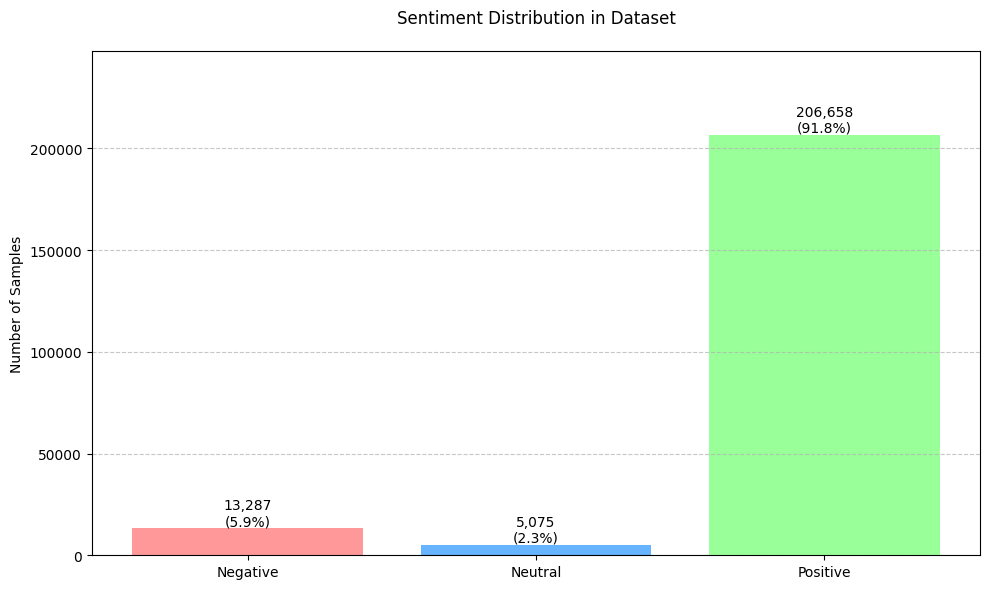


Detailed Sentiment Distribution Statistics:
--------------------------------------------------
Sentiment  Count        Percentage
--------------------------------------------------
Negative   13,287       5.90      %
Neutral    5,075        2.26      %
Positive   206,658      91.84     %
--------------------------------------------------
Total: 225,020 samples

Class Imbalance Metrics:
Imbalance Ratio (Positive:Neutral): 40.72:1
Most frequent sentiment: Positive (206,658 samples)
Least frequent sentiment: Neutral (5,075 samples)


In [7]:
def analyze_sentiment_distribution(y, title="Sentiment Distribution in Dataset"):
    """
    Create a single comprehensive bar chart showing sentiment distribution with both counts and percentages
    """
    # Define sentiment labels
    sentiment_labels = ['Negative', 'Neutral', 'Positive']

    # Calculate distribution
    unique_classes, class_counts = np.unique(y, return_counts=True)
    total_samples = len(y)
    class_percentages = (class_counts / total_samples) * 100

    # Create the figure
    plt.figure(figsize=(10, 6))

    # Create bar plot
    colors = ['#ff9999', '#66b3ff', '#99ff99']  # Red, Blue, Green
    bars = plt.bar(sentiment_labels, class_counts, color=colors)

    # Primary y-axis (counts)
    plt.ylabel('Number of Samples', color='black')
    plt.tick_params(axis='y', labelcolor='black')

    # Add count and percentage labels on top of bars
    for bar, count, percentage in zip(bars, class_counts, class_percentages):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(count):,}\n({percentage:.1f}%)',
                ha='center', va='bottom')

    # Adjust y-axis limits to prevent cutting off labels
    plt.margins(y=0.2)  # Add 20% padding to the top

    # Customize the plot
    plt.title(title, pad=20)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()

    # Print detailed statistics
    print("\nDetailed Sentiment Distribution Statistics:")
    print("-" * 50)
    print(f"{'Sentiment':<10} {'Count':<12} {'Percentage':<10}")
    print("-" * 50)
    for label, count, pct in zip(sentiment_labels, class_counts, class_percentages):
        print(f"{label:<10} {count:<12,} {pct:<10.2f}%")
    print("-" * 50)
    print(f"Total: {total_samples:,} samples")

    # Calculate and print imbalance metrics
    max_count = max(class_counts)
    min_count = min(class_counts)
    imbalance_ratio = max_count / min_count
    majority_sentiment = sentiment_labels[np.argmax(class_counts)]
    minority_sentiment = sentiment_labels[np.argmin(class_counts)]

    print(f"\nClass Imbalance Metrics:")
    print(f"Imbalance Ratio ({majority_sentiment}:{minority_sentiment}): {imbalance_ratio:.2f}:1")
    print(f"Most frequent sentiment: {majority_sentiment} ({max_count:,} samples)")
    print(f"Least frequent sentiment: {minority_sentiment} ({min_count:,} samples)")

# Usage
print("Overall Dataset Sentiment Distribution:")
analyze_sentiment_distribution(y)

# Naive Bayes implementation
This section implements the Naive Bayes model, makes predictions, and generates all the required metrics and visualizations. It uses the helper functions defined in the previous section and NB specific function below for consistency across all models.

In [8]:
# Model Training and Selection
# Test different n-gram ranges to find optimal model configuration.
def evaluate_nb_with_ngrams(X_train, y_train, X_test, y_test, ngram_range):
    # Start total pipeline timer
    total_start_time = time.time()

    # Time vectorization
    vectorization_start = time.time()
    vectorizer = CountVectorizer(ngram_range=ngram_range)
    X_train_vectorized = vectorizer.fit_transform(X_train)
    X_test_vectorized = vectorizer.transform(X_test)
    vectorization_time = time.time() - vectorization_start

    training_start = time.time()
    nb_model = MultinomialNB()
    nb_model.fit(X_train_vectorized, y_train)
    training_time = time.time() - training_start

    prediction_start = time.time()
    y_pred = nb_model.predict(X_test_vectorized)
    prediction_time = time.time() - prediction_start
    accuracy = accuracy_score(y_test, y_pred)

    total_time = time.time() - total_start_time


    print(f"N-gram range: {ngram_range}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Vectorization Time: {vectorization_time:.2f} seconds")
    print(f"Training Time: {training_time:.2f} seconds")
    print(f"Prediction Time: {prediction_time:.2f} seconds")
    print(f"Total Pipeline Time: {total_time:.2f} seconds")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))
    print("-" * 50)

    return nb_model, vectorizer, y_pred, nb_model.predict_proba(X_test_vectorized), training_time, prediction_time, total_time

# Results Visualization and Analysis
def create_nb_model_summary_figure(model):
    print("Model Summary\n\n"
             f"Naive Bayes Model Details:\n{str(model)}\n\n"
             f"Model Parameters:\n{str(model.__dict__)}")

def create_nb_confusion_matrix_figure(y_test, y_pred):
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Neutral', 'Positive'],
                yticklabels=['Negative', 'Neutral', 'Positive'])
    plt.title(f'Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.savefig(f'NB_confusion_matrix.png')
    plt.show()

def create_nb_classification_report_figure(y_test, y_pred):
    plt.figure(figsize=(10, 6))
    report = classification_report(y_test, y_pred, digits=4)
    plt.text(0.1, 0.9,
             f"Classification Report\n\n{report}",
             fontsize=10, family='monospace', verticalalignment='top')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(f'NB_classification_report.png')
    plt.show()



## Data preparation for the NB model

In [9]:
def sequences_to_text(sequences, word_index):
    reverse_word_index = {v: k for k, v in word_index.items()}
    return [' '.join([reverse_word_index.get(i, '') for i in sequence if i != 0]) for sequence in sequences]

# Create split for Naive Bayes
X_train_nb, X_test_nb, y_train_nb, y_test_nb = train_test_split(X, y, test_size=0.25, random_state=42)

X_train_nb_text = sequences_to_text(X_train_nb, word_index)
X_test_nb_text = sequences_to_text(X_test_nb, word_index)

##Run the NB Model

N-gram range: (1, 1)
Accuracy: 0.9339
Vectorization Time: 3.36 seconds
Training Time: 0.04 seconds
Prediction Time: 0.01 seconds
Total Pipeline Time: 3.40 seconds

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.71      0.69      3302
           1       0.23      0.35      0.28      1276
           2       0.98      0.96      0.97     51677

    accuracy                           0.93     56255
   macro avg       0.63      0.67      0.64     56255
weighted avg       0.94      0.93      0.94     56255

--------------------------------------------------
N-gram range: (1, 2)
Accuracy: 0.9553
Vectorization Time: 9.62 seconds
Training Time: 0.11 seconds
Prediction Time: 0.03 seconds
Total Pipeline Time: 9.75 seconds

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.75      0.75      3302
           1       1.00      0.00      0.00      1276
           2       0.97      0.

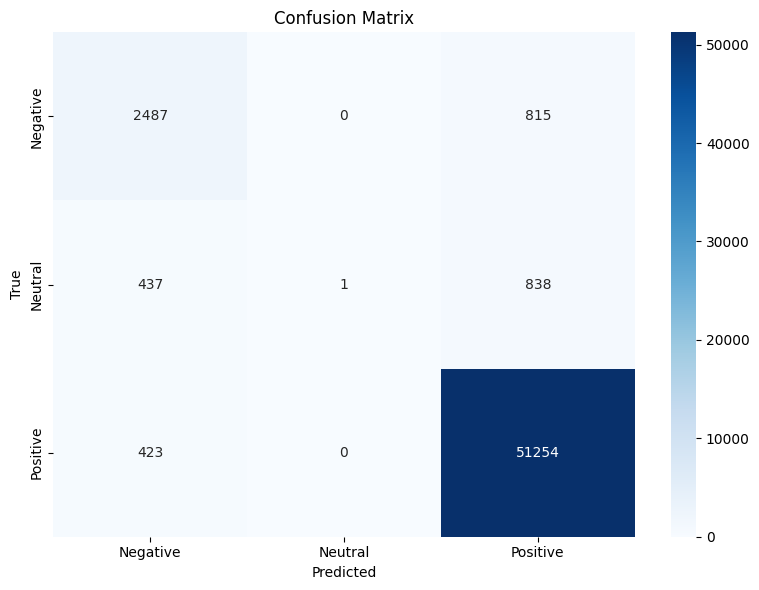

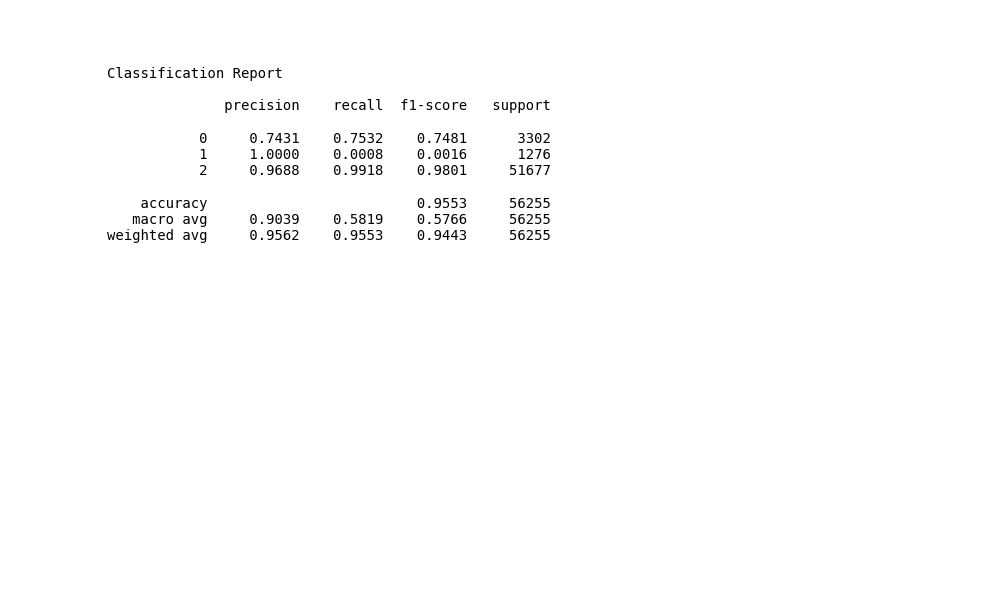

Best n-gram range: (1, 2)
Best Model Accuracy: 0.9553
Training Time: 0.11 seconds
Prediction Time: 0.03 seconds
Pipeline Time: 9.75 seconds


In [10]:
# Test different n-gram ranges
ngram_ranges = [(1, 1), (1, 2), (1, 3), (2, 2), (2, 3)]
best_model, best_accuracy = None, 0
for ngram_range in ngram_ranges:
    model, vectorizer, predictions, probabilities, train_time, prediction_time, pipeline_time = evaluate_nb_with_ngrams(
        X_train_nb_text, y_train_nb, X_test_nb_text, y_test_nb, ngram_range
    )
    accuracy = accuracy_score(y_test_nb, predictions)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
        best_vectorizer = vectorizer
        best_predictions = predictions
        best_probabilities = probabilities
        best_train_time = train_time
        best_prediction_time = prediction_time
        best_pipeline_time = pipeline_time
        best_ngram_range = ngram_range

# Generate and display results
create_nb_model_summary_figure(best_model)
create_nb_confusion_matrix_figure(y_test_nb, best_predictions)
create_nb_classification_report_figure(y_test_nb, best_predictions)

# Store Results for Comparison
nb_results_dict = {
    'model': best_model,
    'accuracy': best_accuracy,
    'train_time': best_train_time,
    'prediction_time': best_prediction_time,
    'pipeline_time': best_pipeline_time,
    'y_true': y_test_nb,
    'y_pred': best_predictions,
    'y_pred_proba': best_probabilities
}

print(f"Best n-gram range: {best_ngram_range}")
print(f"Best Model Accuracy: {best_accuracy:.4f}")
print(f"Training Time: {best_train_time:.2f} seconds")
print(f"Prediction Time: {best_prediction_time:.2f} seconds")
print(f"Pipeline Time: {best_pipeline_time:.2f} seconds")

# CNN
This section defines, trains, and evaluates the CNN model. It includes all the necessary metrics and visualizations, using the helper functions defined earlier.

In [11]:
def create_and_train_cnn(embedding_dim, num_words, max_length, X_train, y_train, X_test, y_test, embedding_matrix):

    start_pipeline_time = time.time()
    num_classes = y_train.shape[1]  # Get the number of classes from y_train

    model_start = time.time()
    model = Sequential([
        Input(shape=(max_length,)),
        Embedding(num_words, embedding_dim, trainable=False, name='embedding'),
        Conv1D(128, 5, activation='relu', name='conv1d'),
        GlobalMaxPooling1D(name='global_max_pooling1d'),
        Dense(10, activation='relu', name='dense_1'),
        Dropout(0.2, name='dropout'),
        Dense(num_classes, activation='softmax', name='output')
    ])

    # Set the embedding weights after layer creation
    model.get_layer('embedding').set_weights([embedding_matrix])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model_time = time.time() - model_start


    # Train the model and measure training time
    start_time = time.time()
    history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test), verbose=1)
    train_time = time.time() - start_time

    pipeline_time = time.time() - start_pipeline_time

    return model, history, train_time, model_time, pipeline_time

def compare_cnn_variations(cnn_results):
    cnn_df = pd.DataFrame(cnn_results, columns=['Embedding Dim', 'Accuracy', 'F1-Score', 'AUC-ROC', 'Training Time'])
    # Replace infinity values with NaN
    cnn_df = cnn_df.replace([np.inf, -np.inf], np.nan)

    # Plotting
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=cnn_df, x='Embedding Dim', y='Accuracy', marker='o', label='Accuracy')
    sns.lineplot(data=cnn_df, x='Embedding Dim', y='F1-Score', marker='s', label='F1-Score')
    plt.title('CNN Performance across Embedding Dimensions')
    plt.xlabel('Embedding Dimension')
    plt.ylabel('Score')
    plt.legend()
    plt.show()

    # Print results
    print("CNN Variation Results:")
    print(cnn_df.to_string(index=False))

    # Determine best configuration
    best_cnn = cnn_df.loc[cnn_df['Accuracy'].idxmax()]
    print(f"\nBest CNN Configuration: Embedding Dim = {best_cnn['Embedding Dim']}")
    print(f"Best Accuracy: {best_cnn['Accuracy']:.4f}")
    print(f"Best F1-Score: {best_cnn['F1-Score']:.4f}")


## Data preparation

In [12]:
# Create a specific split for CNN
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(X, y, test_size=0.2, random_state=42)

# Pad sequences
max_length = 500
X_train_cnn_padded = pad_sequences(X_train_cnn, maxlen=max_length)
X_test_cnn_padded = pad_sequences(X_test_cnn, maxlen=max_length)

# Convert labels to categorical
num_classes = len(np.unique(y_train_cnn))
y_train_cnn_cat = to_categorical(y_train_cnn, num_classes=num_classes)
y_test_cnn_cat = to_categorical(y_test_cnn, num_classes=num_classes)

## Test the variations of the CNN model


Training CNN with embedding dimension: 100
Epoch 1/5
5626/5626 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - accuracy: 0.9060 - loss: 0.2497 - val_accuracy: 0.9569 - val_loss: 0.1333
Epoch 2/5
5626/5626 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.9581 - loss: 0.1296 - val_accuracy: 0.9587 - val_loss: 0.1301
Epoch 3/5
5626/5626 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.9638 - loss: 0.1095 - val_accuracy: 0.9586 - val_loss: 0.1387
Epoch 4/5
5626/5626 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.9677 - loss: 0.0903 - val_accuracy: 0.9567 - val_loss: 0.1483
Epoch 5/5
5626/5626 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.9725 - loss: 0.0734 - val_accuracy: 0.9554 - val_loss: 0.1766
Test Accuracy: 0.9554
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Training CNN with embedding dimension: 200
Epoch 1/5
5626/5626 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9330 - loss: 0.2100 - val_accuracy: 0.9542 - val_loss: 0.1438
Epoch 2/5
5626/5626 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0

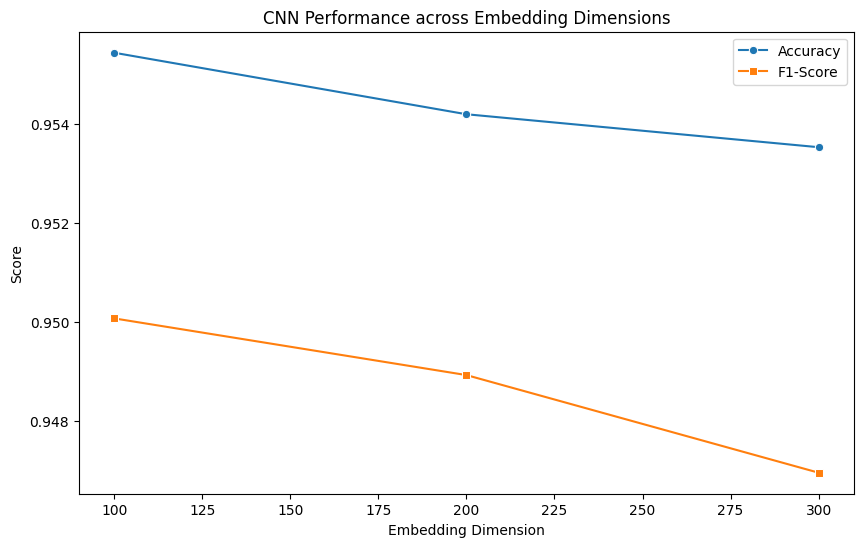

CNN Variation Results:
 Embedding Dim  Accuracy  F1-Score  AUC-ROC  Training Time
           100  0.955448  0.950076 0.968560      73.716808
           200  0.954204  0.948929 0.969911      73.234947
           300  0.953537  0.946954 0.968964      79.227490

Best CNN Configuration: Embedding Dim = 100.0
Best Accuracy: 0.9554
Best F1-Score: 0.9501

Best embedding dimension: 100
Best Accuracy: 0.9554
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Metrics for CNN (Embedding Dim: 100):
Accuracy: 0.9554
Precision: 0.9462
Recall: 0.9554
F1 Score: 0.9501

Class-wise metrics:
Class 0: Precision: 0.7853, Recall: 0.7395, F1: 0.7617
Class 1: Precision: 0.2711, Recall: 0.1232, F1: 0.1694
Class 2: Precision: 0.9730, Recall: 0.9896, F1: 0.9812

Confusion Matrix:
[[ 1950   178   509]
 [  263   125   627]
 [  270   158 40924]]


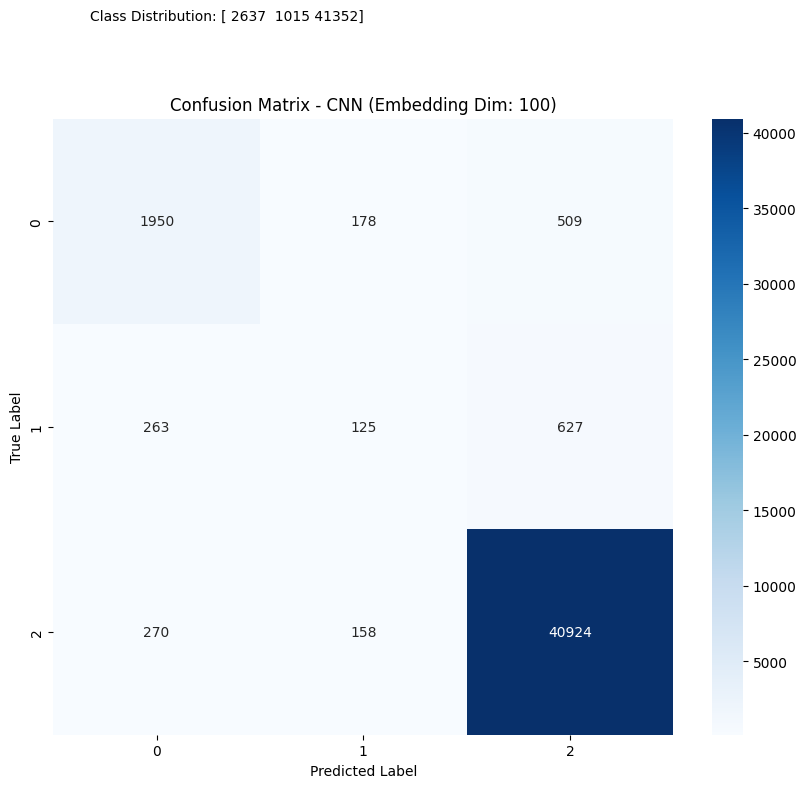

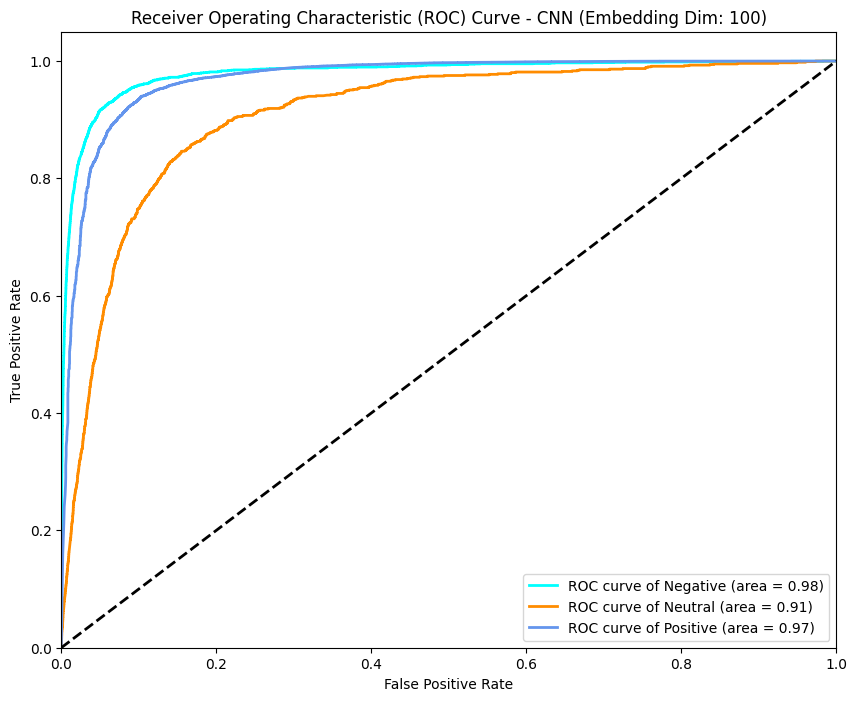


Classification Report - CNN (Embedding Dim: 100):
              precision    recall  f1-score   support

           0       0.79      0.74      0.76      2637
           1       0.27      0.12      0.17      1015
           2       0.97      0.99      0.98     41352

    accuracy                           0.96     45004
   macro avg       0.68      0.62      0.64     45004
weighted avg       0.95      0.96      0.95     45004



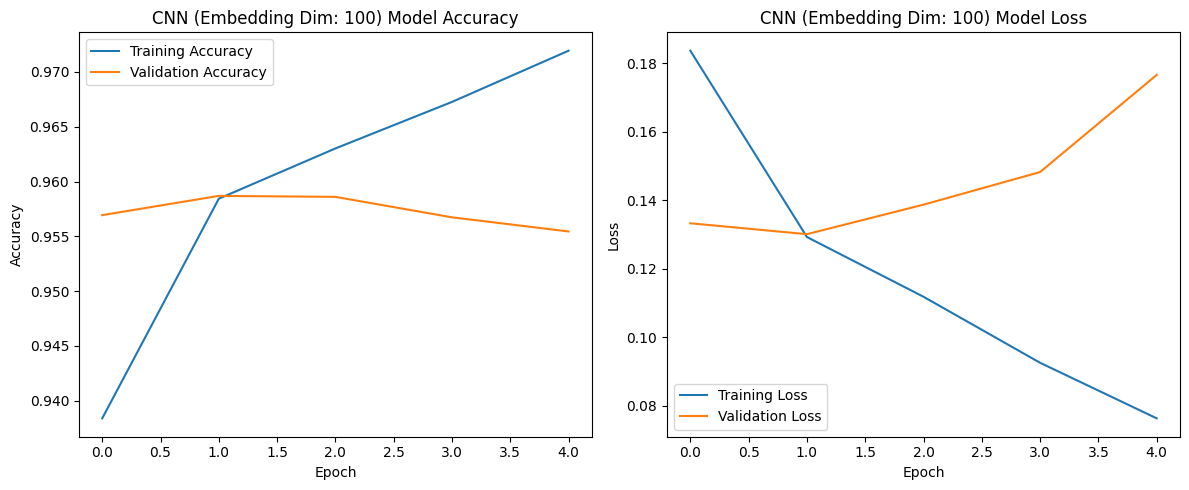


Analysis for CNN (Embedding Dim: 100):
Class distribution in true labels:
Class 0: 2637
Class 1: 1015
Class 2: 41352

Class distribution in predictions:
Class 0: 2483
Class 1: 461
Class 2: 42060
Model Summary


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                       ┃ Output Shape                  ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ embedding (Embedding)              │ (None, 500, 100)              │   1,000,000 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ conv1d (Conv1D)                    │ (None, 496, 128)              │      64,128 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ global_max_pooling1d               │ (None, 128)                   │           0 │
│ (GlobalMaxPooling1D)               │                               │             │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_1 (Dense)                    │ (None, 10)                    │       1,290 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dropout (Dropout)                  │ (None, 10)                    │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ output (Dense)                     │ (None, 3)                     │          33 │
└────────────────────────────────────┴───────────────────────────────┴─────────────┘

 Total params: 3,196,355 (12.19 MB)

 Trainable params: 1,065,451 (4.06 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,130,904 (8.13 MB)

Best Model Accuracy: 0.9554
Training Time: 73.72 seconds
Prediction Time: 2.20 seconds
Pipeline Time: 74.49 seconds


In [13]:
# Test different embedding dimensions
embedding_dims = [100, 200, 300]
num_words = min(10000, len(word_index) + 1)  # Assuming word_index is defined

best_model = None
best_accuracy = 0
best_history = None
best_dim = None

cnn_results = []

for dim in embedding_dims:
    print(f"\nTraining CNN with embedding dimension: {dim}")

    # Load GloVe embeddings for the current dimension
    embedding_matrix = load_glove_embeddings(word_index, dim)

    model, history, train_time, model_time, pipeline_time = create_and_train_cnn(dim, num_words, max_length, X_train_cnn_padded, y_train_cnn_cat, X_test_cnn_padded, y_test_cnn_cat, embedding_matrix)

    # Evaluate the model
    loss, accuracy = model.evaluate(X_test_cnn_padded, y_test_cnn_cat, verbose=0)
    print(f"Test Accuracy: {accuracy:.4f}")

    # Calculate F1-Score
    y_pred = model.predict(X_test_cnn_padded)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test_cnn_cat, axis=1)
    f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

    # Calculate AUC-ROC
    auc_roc = roc_auc_score(y_test_cnn_cat, y_pred, multi_class='ovr', average='weighted')

    # Record results
    cnn_results.append([dim, accuracy, f1, auc_roc, train_time])

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
        best_history = history
        best_dim = dim
        best_train_time = train_time
        best_model_time = model_time
        best_pipeline_time = pipeline_time

# Compare CNN variations
compare_cnn_variations(cnn_results)

print(f"\nBest embedding dimension: {best_dim}")
print(f"Best Accuracy: {best_accuracy:.4f}")

# Use the best model for further analysis
cnn_model = best_model
history_cnn = best_history

# Make predictions using the best model
prediction_start = time.time()
y_pred_cnn = cnn_model.predict(X_test_cnn_padded)
best_prediction_time = time.time() - prediction_start
y_pred_classes_cnn = np.argmax(y_pred_cnn, axis=1)

# Print metrics
print_metrics(y_test_cnn, y_pred_classes_cnn, f"CNN (Embedding Dim: {best_dim})")

# Plot confusion matrix
plot_confusion_matrix(y_test_cnn, y_pred_classes_cnn, f"CNN (Embedding Dim: {best_dim})")

# Plot ROC curve
plot_roc_curve(y_test_cnn, y_pred_cnn, f"CNN (Embedding Dim: {best_dim})")

# Print classification report
print(f"\nClassification Report - CNN (Embedding Dim: {best_dim}):")
print(classification_report(y_test_cnn, y_pred_classes_cnn, zero_division=0))

# Plot training history
plot_training_history(history_cnn, f"CNN (Embedding Dim: {best_dim})")

# Analyze predictions
analyze_predictions(y_test_cnn, y_pred_classes_cnn, f"CNN (Embedding Dim: {best_dim})")

# Store results for later comparison
cnn_results_dict = {
    'model': best_model,
    'embedding_dim': best_dim,
    'accuracy': best_accuracy,
    'train_time': best_train_time,
    'prediction_time': best_prediction_time,
    'pipeline_time': best_pipeline_time,
    'model_time': best_model_time,
    'y_true': y_test_cnn,
    'y_pred': y_pred_classes_cnn,
    'y_pred_proba': y_pred_cnn
}
# Present results for best model only
print("Model Summary")
best_model.summary()

print(f"Best Model Accuracy: {best_accuracy:.4f}")
print(f"Training Time: {best_train_time:.2f} seconds")
print(f"Prediction Time: {best_prediction_time:.2f} seconds")
print(f"Pipeline Time: {best_pipeline_time:.2f} seconds")

# BiLSTM
This section defines, trains, and evaluates the BiLSTM model. It includes all the necessary metrics and visualizations, using the helper functions defined earlier.


In [14]:
# Function to create and train BiLSTM model
def create_and_train_bilstm(embedding_dim, num_words, max_length, lstm_units, X_train, y_train, X_test, y_test, embedding_matrix):

    pipeline_start = time.time()
    num_classes = y_train.shape[1]  # Get the number of classes from y_train

    model_start = time.time()
    model = Sequential([
        Input(shape=(max_length,)),
        Embedding(num_words, embedding_dim, trainable=False, name='embedding'),
        Bidirectional(LSTM(lstm_units, return_sequences=True), name='bilstm_1'),
        Bidirectional(LSTM(lstm_units // 2), name='bilstm_2'),
        Dense(10, activation='relu', name='dense_1'),
        Dropout(0.2, name='dropout'),
        Dense(num_classes, activation='softmax', name='output')
    ])

    # Set the embedding weights after layer creation
    model.get_layer('embedding').set_weights([embedding_matrix])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model_time = time.time() - model_start

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Train the model and measure training time
    start_time = time.time()
    history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)
    train_time = time.time() - start_time

    pipeline_time = time.time() - pipeline_start

    return model, history, train_time, model_time, pipeline_time

def compare_bilstm_variations(bilstm_results):
    bilstm_df = pd.DataFrame(bilstm_results, columns=['LSTM Units', 'Accuracy', 'F1-Score', 'AUC-ROC', 'Training Time'])

    # Plotting
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=bilstm_df, x='LSTM Units', y='Accuracy', marker='o', label='Accuracy')
    sns.lineplot(data=bilstm_df, x='LSTM Units', y='F1-Score', marker='s', label='F1-Score')
    plt.title('BiLSTM Performance across LSTM Units')
    plt.xlabel('LSTM Units')
    plt.ylabel('Score')
    plt.legend()
    plt.show()

    # Print results
    print("BiLSTM Variation Results:")
    print(bilstm_df.to_string(index=False))

    # Determine best configuration
    best_bilstm = bilstm_df.loc[bilstm_df['Accuracy'].idxmax()]
    print(f"\nBest BiLSTM Configuration: LSTM Units = {best_bilstm['LSTM Units']}")
    print(f"Best Accuracy: {best_bilstm['Accuracy']:.4f}")
    print(f"Best F1-Score: {best_bilstm['F1-Score']:.4f}")
    print(f"Training time for best configuration: {best_bilstm['Training Time']:.4f}")


# Common setup (move this outside the loop)
X_train_bilstm, X_test_bilstm, y_train_bilstm, y_test_bilstm = train_test_split(X, y, test_size=0.25, random_state=42)

# Pad sequences
max_length = 500
X_train_bilstm_padded = pad_sequences(X_train_bilstm, maxlen=max_length)
X_test_bilstm_padded = pad_sequences(X_test_bilstm, maxlen=max_length)

# Convert labels to categorical
num_classes = len(np.unique(y_train_bilstm))
y_train_bilstm_cat = to_categorical(y_train_bilstm, num_classes=num_classes)
y_test_bilstm_cat = to_categorical(y_test_bilstm, num_classes=num_classes)

embedding_dim = best_dim  # Set to best performing from CNN model
num_words = min(10000, len(word_index) + 1)

# Load GloVe embeddings
print(f"\nLoading best embeddings dimensions as found by CNN: {embedding_dim}")
embedding_matrix = load_glove_embeddings(word_index, embedding_dim)

# Initialize variables to track best model
best_model = None
best_accuracy = 0
best_history = None
best_units = None
best_train_time = 0
bilstm_results = []




Loading best embeddings dimensions as found by CNN: 100


In [15]:
# First iteration: 64 LSTM units
lstm_units = 64
print(f"\nTraining BiLSTM with {lstm_units} LSTM units")

model_64, history_64, train_time_64, model_time_64, pipeline_time_64 = create_and_train_bilstm(embedding_dim, num_words, max_length, lstm_units,
                                                              X_train_bilstm_padded, y_train_bilstm_cat,
                                                              X_test_bilstm_padded, y_test_bilstm_cat,
                                                              embedding_matrix)

# Evaluate the model
loss_64, accuracy_64 = model_64.evaluate(X_test_bilstm_padded, y_test_bilstm_cat, verbose=0)
print(f"Test Accuracy: {accuracy_64:.4f}")

# Calculate F1-Score
y_pred_64 = model_64.predict(X_test_bilstm_padded)
y_pred_classes_64 = np.argmax(y_pred_64, axis=1)
y_true_classes = np.argmax(y_test_bilstm_cat, axis=1)
f1_64 = f1_score(y_true_classes, y_pred_classes_64, average='weighted')

# Calculate AUC-ROC
auc_roc_64 = roc_auc_score(y_test_bilstm_cat, y_pred_64, multi_class='ovr', average='weighted')

# Record results
bilstm_results.append([lstm_units, accuracy_64, f1_64, auc_roc_64, train_time_64])

# Update best model if needed
if accuracy_64 > best_accuracy:
    best_accuracy = accuracy_64
    best_model = model_64
    best_history = history_64
    best_units = lstm_units
    best_train_time = train_time_64
    best_model_time = model_time_64
    best_pipeline_time = pipeline_time_64


Training BiLSTM with 64 LSTM units
Epoch 1/5
5274/5274 ━━━━━━━━━━━━━━━━━━━━ 350s 65ms/step - accuracy: 0.9380 - loss: 0.2169 - val_accuracy: 0.9571 - val_loss: 0.1322
Epoch 2/5
5274/5274 ━━━━━━━━━━━━━━━━━━━━ 345s 65ms/step - accuracy: 0.9584 - loss: 0.1327 - val_accuracy: 0.9592 - val_loss: 0.1261
Epoch 3/5
5274/5274 ━━━━━━━━━━━━━━━━━━━━ 346s 66ms/step - accuracy: 0.9626 - loss: 0.1130 - val_accuracy: 0.9596 - val_loss: 0.1283
Epoch 4/5
5274/5274 ━━━━━━━━━━━━━━━━━━━━ 339s 64ms/step - accuracy: 0.9649 - loss: 0.1045 - val_accuracy: 0.9585 - val_loss: 0.1324
Epoch 5/5
5274/5274 ━━━━━━━━━━━━━━━━━━━━ 335s 64ms/step - accuracy: 0.9693 - loss: 0.0893 - val_accuracy: 0.9585 - val_loss: 0.1435
Test Accuracy: 0.9592
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 41s 23ms/step


In [16]:
# Second iteration: 128 LSTM units
lstm_units = 128
print(f"\nTraining BiLSTM with {lstm_units} LSTM units")

model_128, history_128, train_time_128, model_time_128, pipeline_time_128 = create_and_train_bilstm(embedding_dim, num_words, max_length, lstm_units,
                                                                 X_train_bilstm_padded, y_train_bilstm_cat,
                                                                 X_test_bilstm_padded, y_test_bilstm_cat,
                                                                 embedding_matrix)

# Evaluate the model
loss_128, accuracy_128 = model_128.evaluate(X_test_bilstm_padded, y_test_bilstm_cat, verbose=0)
print(f"Test Accuracy: {accuracy_128:.4f}")

# Calculate F1-Score
y_pred_128 = model_128.predict(X_test_bilstm_padded)
y_pred_classes_128 = np.argmax(y_pred_128, axis=1)
f1_128 = f1_score(y_true_classes, y_pred_classes_128, average='weighted')

# Calculate AUC-ROC
auc_roc_128 = roc_auc_score(y_test_bilstm_cat, y_pred_128, multi_class='ovr', average='weighted')

# Record results
bilstm_results.append([lstm_units, accuracy_128, f1_128, auc_roc_128, train_time_128])

# Update best model if needed
if accuracy_128 > best_accuracy:
    best_accuracy = accuracy_128
    best_model = model_128
    best_history = history_128
    best_units = lstm_units
    best_train_time = train_time_128
    best_model_time = model_time_128
    best_pipeline_time = pipeline_time_128


Training BiLSTM with 128 LSTM units
Epoch 1/5
5274/5274 ━━━━━━━━━━━━━━━━━━━━ 362s 68ms/step - accuracy: 0.9389 - loss: 0.2050 - val_accuracy: 0.9583 - val_loss: 0.1296
Epoch 2/5
5274/5274 ━━━━━━━━━━━━━━━━━━━━ 357s 68ms/step - accuracy: 0.9578 - loss: 0.1315 - val_accuracy: 0.9585 - val_loss: 0.1258
Epoch 3/5
5274/5274 ━━━━━━━━━━━━━━━━━━━━ 360s 68ms/step - accuracy: 0.9619 - loss: 0.1125 - val_accuracy: 0.9593 - val_loss: 0.1254
Epoch 4/5
5274/5274 ━━━━━━━━━━━━━━━━━━━━ 360s 68ms/step - accuracy: 0.9662 - loss: 0.0981 - val_accuracy: 0.9596 - val_loss: 0.1295
Epoch 5/5
5274/5274 ━━━━━━━━━━━━━━━━━━━━ 368s 70ms/step - accuracy: 0.9702 - loss: 0.0895 - val_accuracy: 0.9583 - val_loss: 0.1368
Test Accuracy: 0.9583
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 41s 23ms/step


In [17]:
# Third iteration: 256 LSTM units
lstm_units = 256
print(f"\nTraining BiLSTM with {lstm_units} LSTM units")

model_256, history_256, train_time_256, model_time_256, pipeline_time_256 = create_and_train_bilstm(embedding_dim, num_words, max_length, lstm_units,
                                                                 X_train_bilstm_padded, y_train_bilstm_cat,
                                                                 X_test_bilstm_padded, y_test_bilstm_cat,
                                                                 embedding_matrix)

# Evaluate the model
loss_256, accuracy_256 = model_256.evaluate(X_test_bilstm_padded, y_test_bilstm_cat, verbose=0)
print(f"Test Accuracy: {accuracy_256:.4f}")

# Calculate F1-Score
y_pred_256 = model_256.predict(X_test_bilstm_padded)
y_pred_classes_256 = np.argmax(y_pred_256, axis=1)
f1_256 = f1_score(y_true_classes, y_pred_classes_256, average='weighted')

# Calculate AUC-ROC
auc_roc_256 = roc_auc_score(y_test_bilstm_cat, y_pred_256, multi_class='ovr', average='weighted')

# Record results
bilstm_results.append([lstm_units, accuracy_256, f1_256, auc_roc_256, train_time_256])

# Update best model if needed
if accuracy_256 > best_accuracy:
    best_accuracy = accuracy_256
    best_model = model_256
    best_history = history_256
    best_units = lstm_units
    best_train_time = train_time_256
    best_model_time = model_time_256
    best_pipeline_time = pipeline_time_256


Training BiLSTM with 256 LSTM units
Epoch 1/5
5274/5274 ━━━━━━━━━━━━━━━━━━━━ 382s 72ms/step - accuracy: 0.9357 - loss: 0.2174 - val_accuracy: 0.9568 - val_loss: 0.1320
Epoch 2/5
5274/5274 ━━━━━━━━━━━━━━━━━━━━ 379s 72ms/step - accuracy: 0.9588 - loss: 0.1329 - val_accuracy: 0.9578 - val_loss: 0.1315
Epoch 3/5
5274/5274 ━━━━━━━━━━━━━━━━━━━━ 378s 72ms/step - accuracy: 0.9611 - loss: 0.1224 - val_accuracy: 0.9579 - val_loss: 0.1308
Epoch 4/5
5274/5274 ━━━━━━━━━━━━━━━━━━━━ 376s 71ms/step - accuracy: 0.9618 - loss: 0.1162 - val_accuracy: 0.9580 - val_loss: 0.1330
Epoch 5/5
5274/5274 ━━━━━━━━━━━━━━━━━━━━ 371s 70ms/step - accuracy: 0.9651 - loss: 0.1076 - val_accuracy: 0.9590 - val_loss: 0.1274
Test Accuracy: 0.9590
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 44s 25ms/step



Best number of LSTM units: 64
Best Accuracy: 0.9592
Train time for best configuration: 1714.7190091609955
Model time for best configuration: 0.21988606452941895
Pipeline time for best configuration: 1714.9389188289642
Best model summary:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                       ┃ Output Shape                  ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ embedding (Embedding)              │ (None, 500, 100)              │   1,000,000 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ bilstm_1 (Bidirectional)           │ (None, 500, 128)              │      84,480 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ bilstm_2 (Bidirectional)           │ (None, 64)                    │      41,216 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_1 (Dense)                    │ (None, 10)                    │         650 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dropout (Dropout)                  │ (None, 10)                    │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ output (Dense)                     │ (None, 3)                     │          33 │
└────────────────────────────────────┴───────────────────────────────┴─────────────┘

 Total params: 3,379,139 (12.89 MB)

 Trainable params: 1,126,379 (4.30 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,252,760 (8.59 MB)

1758/1758 ━━━━━━━━━━━━━━━━━━━━ 40s 23ms/step

Metrics for BiLSTM (64 units):
Accuracy: 0.9592
Precision: 0.9373
Recall: 0.9592
F1 Score: 0.9481

Class-wise metrics:
Class 0: Precision: 0.7785, Recall: 0.7907, F1: 0.7846
Class 1: Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Class 2: Precision: 0.9706, Recall: 0.9936, F1: 0.9820

Confusion Matrix:
[[ 2611     0   691]
 [  414     0   862]
 [  329     0 51348]]


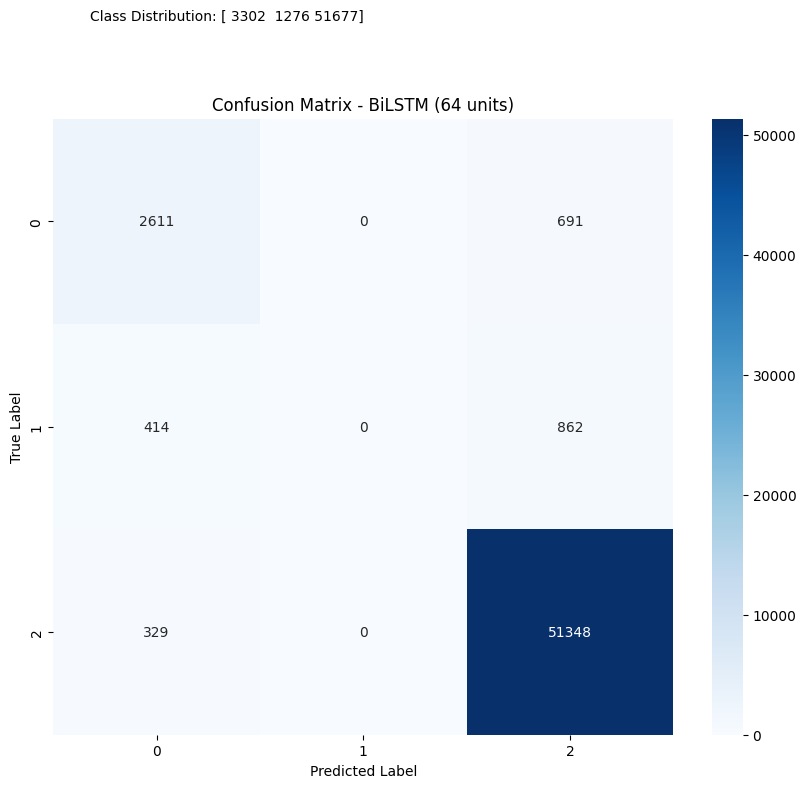

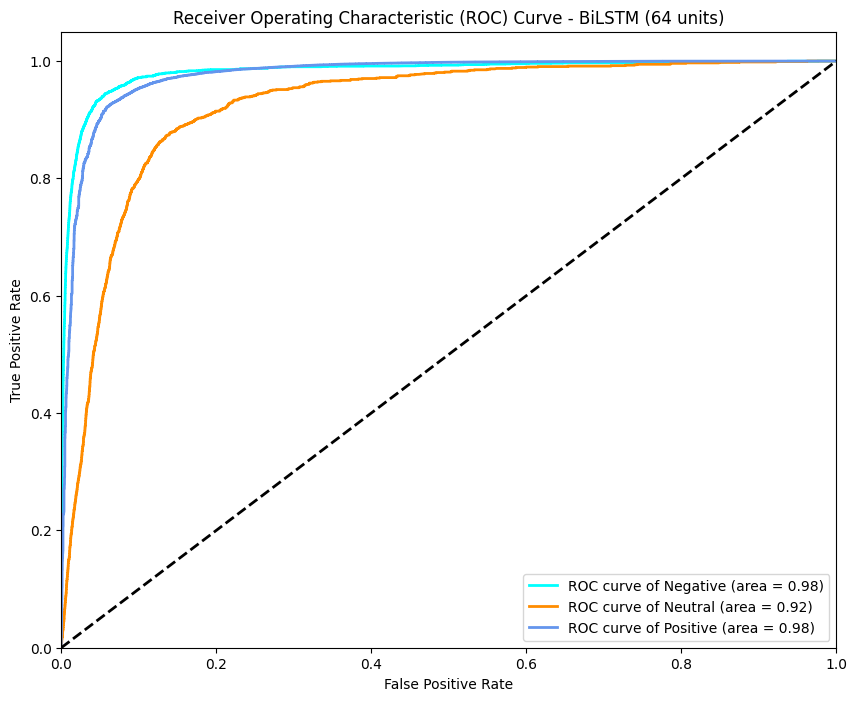


Classification Report - BiLSTM (64 units):
              precision    recall  f1-score   support

           0       0.78      0.79      0.78      3302
           1       0.00      0.00      0.00      1276
           2       0.97      0.99      0.98     51677

    accuracy                           0.96     56255
   macro avg       0.58      0.59      0.59     56255
weighted avg       0.94      0.96      0.95     56255



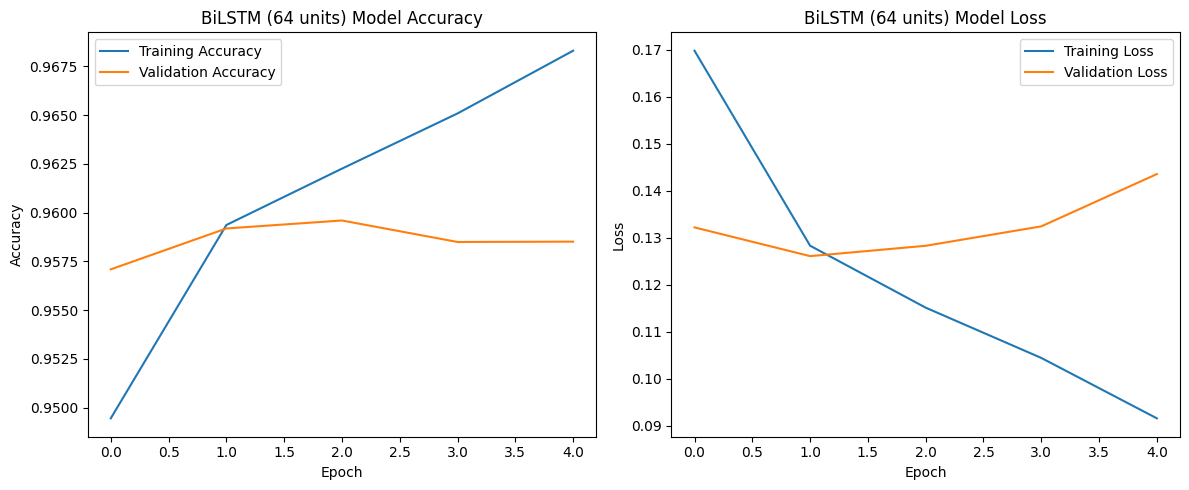


Analysis for BiLSTM (64 units):
Class distribution in true labels:
Class 0: 3302
Class 1: 1276
Class 2: 51677

Class distribution in predictions:
Class 0: 3354
Class 2: 52901

Classes not predicted by the model: {1}


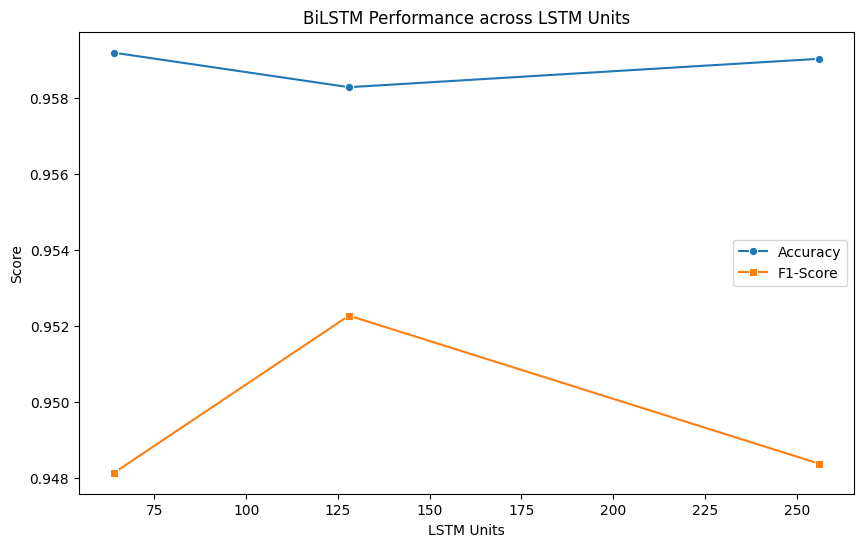

BiLSTM Variation Results:
 LSTM Units  Accuracy  F1-Score  AUC-ROC  Training Time
         64  0.959186  0.948140 0.975332    1714.719009
        128  0.958279  0.952272 0.972751    1807.794237
        256  0.959026  0.948382 0.974946    1885.958446

Best BiLSTM Configuration: LSTM Units = 64.0
Best Accuracy: 0.9592
Best F1-Score: 0.9481
Training time for best configuration: 1714.7190


In [18]:
print(f"\nBest number of LSTM units: {best_units}")
print(f"Best Accuracy: {best_accuracy:.4f}")
print(f"Train time for best configuration: {best_train_time}")
print(f"Model time for best configuration: {best_model_time}")
print(f"Pipeline time for best configuration: {best_pipeline_time}")
print(f"Best model summary:")
best_model.summary()

# Use the best model for further analysis
bilstm_model = best_model
history_bilstm = best_history

# Make predictions using the best model
prediction_start = time.time()
y_pred_bilstm = bilstm_model.predict(X_test_bilstm_padded)
best_prediction_time = time.time() - prediction_start
y_pred_classes_bilstm = np.argmax(y_pred_bilstm, axis=1)

# Print metrics
print_metrics(y_test_bilstm, y_pred_classes_bilstm, f"BiLSTM ({best_units} units)")

# Plot confusion matrix
plot_confusion_matrix(y_test_bilstm, y_pred_classes_bilstm, f"BiLSTM ({best_units} units)")

# Plot ROC curve
plot_roc_curve(y_test_bilstm, y_pred_bilstm, f"BiLSTM ({best_units} units)")

# Print classification report
print(f"\nClassification Report - BiLSTM ({best_units} units):")
print(classification_report(y_test_bilstm, y_pred_classes_bilstm, zero_division=0))

# Plot training history
plot_training_history(history_bilstm, f"BiLSTM ({best_units} units)")

# Analyze predictions
analyze_predictions(y_test_bilstm, y_pred_classes_bilstm, f"BiLSTM ({best_units} units)")

# Store results for later comparison
bilstm_results_dict = {
    'model': bilstm_model,
    'lstm_units': best_units,
    'accuracy': best_accuracy,
    'y_true': y_test_bilstm,
    'y_pred': y_pred_classes_bilstm,
    'y_pred_proba': y_pred_bilstm,
    'train_time': best_train_time,
    'model_time': best_model_time,
    'pipeline_time': best_pipeline_time,
    'prediction_time': best_prediction_time
}

# Compare BiLSTM variations
compare_bilstm_variations(bilstm_results)

# Hybrid CNN-BiLSTM
This section defines, trains, and evaluates the hybrid CNN-BiLSTM model. It includes all the necessary metrics and visualizations, using the helper functions defined earlier.


Training Hybrid CNN-BiLSTM with 64 LSTM units and 100-dimensional embeddings
Epoch 1/5
4923/4923 ━━━━━━━━━━━━━━━━━━━━ 120s 23ms/step - accuracy: 0.9379 - loss: 0.2108 - val_accuracy: 0.9579 - val_loss: 0.1307
Epoch 2/5
4923/4923 ━━━━━━━━━━━━━━━━━━━━ 114s 23ms/step - accuracy: 0.9601 - loss: 0.1285 - val_accuracy: 0.9573 - val_loss: 0.1302
Epoch 3/5
4923/4923 ━━━━━━━━━━━━━━━━━━━━ 115s 23ms/step - accuracy: 0.9621 - loss: 0.1174 - val_accuracy: 0.9588 - val_loss: 0.1309
Epoch 4/5
4923/4923 ━━━━━━━━━━━━━━━━━━━━ 115s 23ms/step - accuracy: 0.9673 - loss: 0.0987 - val_accuracy: 0.9569 - val_loss: 0.1324
Epoch 5/5
4923/4923 ━━━━━━━━━━━━━━━━━━━━ 115s 23ms/step - accuracy: 0.9730 - loss: 0.0794 - val_accuracy: 0.9550 - val_loss: 0.1556
Test Accuracy: 0.9550
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step

Hybrid CNN-BiLSTM Results:
Embedding Dimensions: 100
LSTM Units: 64
Accuracy: 0.9550
F1-Score: 0.9486
AUC-ROC: 0.9654
Training Time: 578.91 seconds
Model Time: 0.04 seconds
Pipeline Time: 578.96 

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                       ┃ Output Shape                  ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ sequential_6 (Sequential)          │ (None, 124, 128)              │   1,064,128 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ bilstm_1 (Bidirectional)           │ (None, 124, 128)              │      98,816 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ bilstm_2 (Bidirectional)           │ (None, 64)                    │      41,216 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_1 (Dense)                    │ (None, 10)                    │         650 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dropout (Dropout)                  │ (None, 10)                    │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ output (Dense)                     │ (None, 3)                     │          33 │
└────────────────────────────────────┴───────────────────────────────┴─────────────┘

 Total params: 3,614,531 (13.79 MB)

 Trainable params: 1,204,843 (4.60 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,409,688 (9.19 MB)


Metrics for Hybrid CNN-BiLSTM (Embed: 100, LSTM: 64):
Accuracy: 0.9550
Precision: 0.9445
Recall: 0.9550
F1 Score: 0.9486

Class-wise metrics:
Class 0: Precision: 0.8145, Recall: 0.6859, F1: 0.7447
Class 1: Precision: 0.2754, Recall: 0.1156, F1: 0.1629
Class 2: Precision: 0.9692, Recall: 0.9927, F1: 0.9808

Confusion Matrix:
[[ 2704   294   944]
 [  332   176  1014]
 [  284   169 61589]]


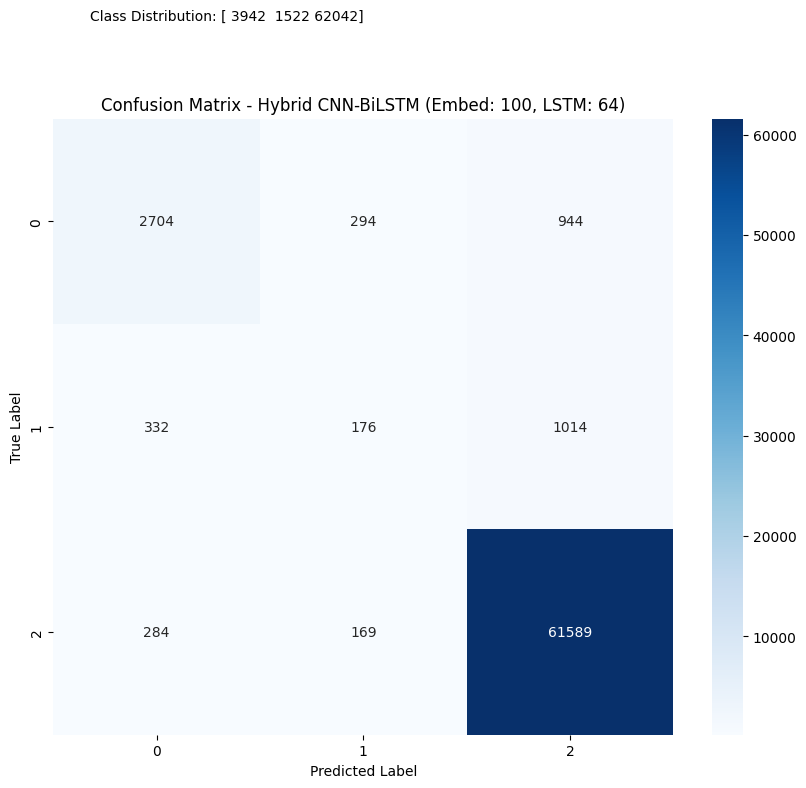

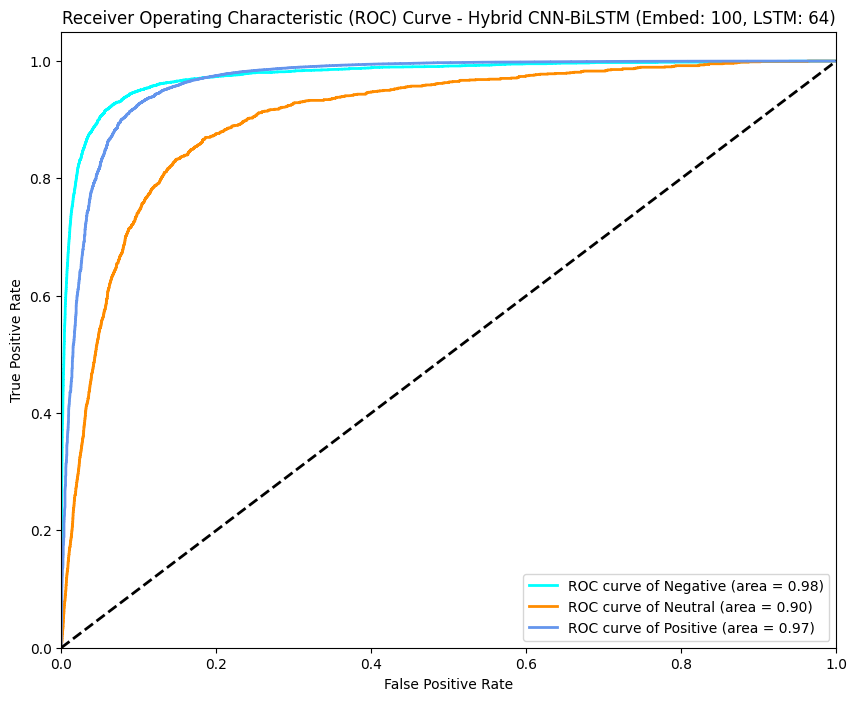


Classification Report - Hybrid CNN-BiLSTM (Embed: 100, LSTM: 64):
              precision    recall  f1-score   support

           0       0.81      0.69      0.74      3942
           1       0.28      0.12      0.16      1522
           2       0.97      0.99      0.98     62042

    accuracy                           0.96     67506
   macro avg       0.69      0.60      0.63     67506
weighted avg       0.94      0.96      0.95     67506



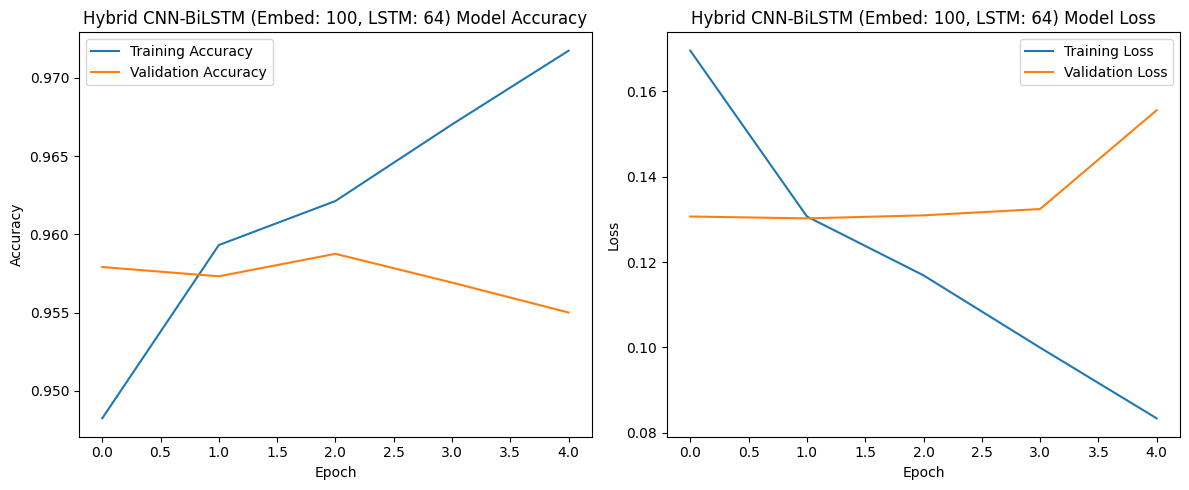


Analysis for Hybrid CNN-BiLSTM (Embed: 100, LSTM: 64):
Class distribution in true labels:
Class 0: 3942
Class 1: 1522
Class 2: 62042

Class distribution in predictions:
Class 0: 3320
Class 1: 639
Class 2: 63547


In [19]:
def create_and_train_hybrid(embedding_dim, num_words, max_length, lstm_units, X_train, y_train, X_test, y_test, embedding_matrix):
    pipeline_start = time.time()
    num_classes = y_train.shape[1]  # Get the number of classes from y_train

    model_start = time.time()
    # First, define the CNN model
    cnn_model = Sequential([
        Input(shape=(max_length,)),
        Embedding(num_words, embedding_dim, trainable=False, name='embedding'),
        Conv1D(128, 5, activation='relu', name='conv1d'),
        MaxPooling1D(pool_size=4, name='max_pooling1d')
    ])

    # Set the embedding weights for the CNN model
    cnn_model.get_layer('embedding').set_weights([embedding_matrix])

    # Now, add BiLSTM layers sequentially
    hybrid_model = Sequential([
        cnn_model,
        Bidirectional(LSTM(lstm_units, return_sequences=True), name='bilstm_1'),
        Bidirectional(LSTM(lstm_units // 2), name='bilstm_2'),
        Dense(10, activation='relu', name='dense_1'),
        Dropout(0.2, name='dropout'),
        Dense(num_classes, activation='softmax', name='output')
    ])

    hybrid_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model_time = time.time() - model_start

    # Train the model and measure training time
    start_time = time.time()
    history = hybrid_model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test), verbose=1)
    train_time = time.time() - start_time

    pipeline_time = time.time() - pipeline_start

    return hybrid_model, history, train_time, model_time, pipeline_time

# Create a specific split for Hybrid model
X_train_hybrid, X_test_hybrid, y_train_hybrid, y_test_hybrid = train_test_split(X, y, test_size=0.3, random_state=42)

# Pad sequences
max_length = 500
X_train_hybrid_padded = pad_sequences(X_train_hybrid, maxlen=max_length)
X_test_hybrid_padded = pad_sequences(X_test_hybrid, maxlen=max_length)

# Convert labels to categorical
num_classes = len(np.unique(y_train_hybrid))
y_train_hybrid_cat = to_categorical(y_train_hybrid, num_classes=num_classes)
y_test_hybrid_cat = to_categorical(y_test_hybrid, num_classes=num_classes)

# Set hyperparameters
lstm_units = best_units # Best from BiLSTM
embedding_dim = best_dim  # Best from CNN
num_words = min(10000, len(word_index) + 1)  # Assuming word_index is defined

# Load GloVe embeddings
embedding_matrix = load_glove_embeddings(word_index, embedding_dim)

print(f"\nTraining Hybrid CNN-BiLSTM with {lstm_units} LSTM units and {embedding_dim}-dimensional embeddings")

model, history, train_time, model_time, pipeline_time = create_and_train_hybrid(embedding_dim, num_words, max_length, lstm_units,
                                                     X_train_hybrid_padded, y_train_hybrid_cat,
                                                     X_test_hybrid_padded, y_test_hybrid_cat,
                                                     embedding_matrix)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_hybrid_padded, y_test_hybrid_cat, verbose=0)
print(f"Test Accuracy: {accuracy:.4f}")

# Calculate F1-Score
y_pred = model.predict(X_test_hybrid_padded)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_hybrid_cat, axis=1)
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

# Calculate AUC-ROC
auc_roc = roc_auc_score(y_test_hybrid_cat, y_pred, multi_class='ovr', average='weighted')

# Print results
print("\nHybrid CNN-BiLSTM Results:")
print(f"Embedding Dimensions: {embedding_dim}")
print(f"LSTM Units: {lstm_units}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")
print(f"Training Time: {train_time:.2f} seconds")
print(f"Model Time: {model_time:.2f} seconds")
print(f"Pipeline Time: {pipeline_time:.2f} seconds")
print(f"Hybrid model summary:")
model.summary()

# Print metrics
print_metrics(y_test_hybrid, y_pred_classes, f"Hybrid CNN-BiLSTM (Embed: {embedding_dim}, LSTM: {lstm_units})")

# Plot confusion matrix
plot_confusion_matrix(y_test_hybrid, y_pred_classes, f"Hybrid CNN-BiLSTM (Embed: {embedding_dim}, LSTM: {lstm_units})")

# Plot ROC curve
plot_roc_curve(y_test_hybrid, y_pred, f"Hybrid CNN-BiLSTM (Embed: {embedding_dim}, LSTM: {lstm_units})")

# Print classification report
print(f"\nClassification Report - Hybrid CNN-BiLSTM (Embed: {embedding_dim}, LSTM: {lstm_units}):")
print(classification_report(y_test_hybrid, y_pred_classes, zero_division=0))

# Plot training history
plot_training_history(history, f"Hybrid CNN-BiLSTM (Embed: {embedding_dim}, LSTM: {lstm_units})")

# Analyze predictions
analyze_predictions(y_test_hybrid, y_pred_classes, f"Hybrid CNN-BiLSTM (Embed: {embedding_dim}, LSTM: {lstm_units})")

hybrid_model = model
y_pred_classes_hybrid = y_pred_classes
y_pred_hybrid = y_pred

# Store results for later comparison
hybrid_results_dict = {
    'model': hybrid_model,
    'embedding_dim': embedding_dim,
    'lstm_units': lstm_units,
    'train_time': train_time,
    'y_true': y_test_hybrid,
    'y_pred': y_pred_classes_hybrid,
    'y_pred_proba': y_pred_hybrid
}

In [20]:
data = bilstm_results_dict
for key, value in data.items():
    print(f"{key}: {value}")

model: <Sequential name=sequential_3, built=True>
lstm_units: 64
accuracy: 0.9591858386993408
y_true: [2 2 2 ... 0 2 2]
y_pred: [2 2 2 ... 0 2 2]
y_pred_proba: [[2.7905151e-04 1.1730141e-03 9.9854785e-01]
 [1.2556316e-01 1.2049740e-01 7.5393945e-01]
 [4.6570629e-02 6.2154759e-02 8.9127463e-01]
 ...
 [9.7127694e-01 2.7728118e-02 9.9491363e-04]
 [6.7674235e-05 3.8600716e-04 9.9954635e-01]
 [8.9085853e-04 2.8670640e-03 9.9624205e-01]]
train_time: 1714.7190091609955
model_time: 0.21988606452941895
pipeline_time: 1714.9389188289642
prediction_time: 40.9193594455719


# Comparison
This final section provides a comprehensive comparison of all four models:

1. It creates bar plots comparing the accuracy, precision, recall, and F1-score of all models.
1. It prints a table with all metrics for easy comparison.
1. It identifies the best performing model for each metric.
1. Finally, it plots ROC curves for all models on the same graph for direct comparison.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


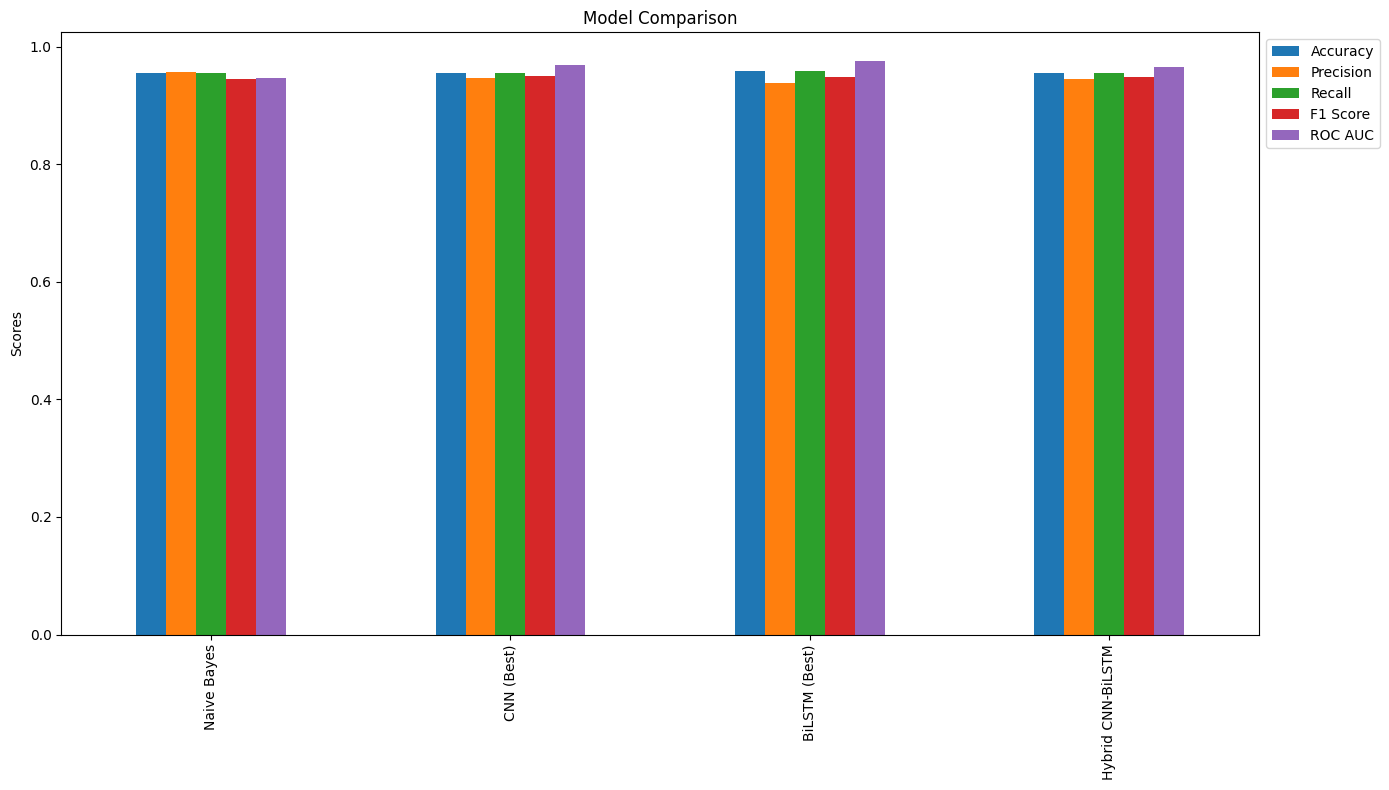


Model Comparison:
                   Accuracy  Precision    Recall  F1 Score   ROC AUC Training Time
Naive Bayes        0.955328   0.956217  0.955328  0.944332  0.946770       0.11 ms
CNN (Best)         0.955448   0.946167  0.955448  0.950076  0.968560       73.72 s
BiLSTM (Best)      0.959186   0.937347  0.959186  0.948140  0.975332     1714.72 s
Hybrid CNN-BiLSTM  0.955011   0.944511  0.955011  0.948574  0.965424      578.91 s

Best Models:
Best Accuracy: BiLSTM (Best) (0.9591858501466536)
Best Precision: Naive Bayes (0.9562170847346871)
Best Recall: BiLSTM (Best) (0.9591858501466536)
Best F1 Score: CNN (Best) (0.9500757109151029)
Best ROC AUC: BiLSTM (Best) (0.9753316113835419)

Model Configurations:

Naive Bayes:

CNN (Best):
  Embedding Dimension: 100

BiLSTM (Best):
  LSTM Units: 64

Hybrid CNN-BiLSTM:
  Embedding Dimension: 100
  LSTM Units: 64


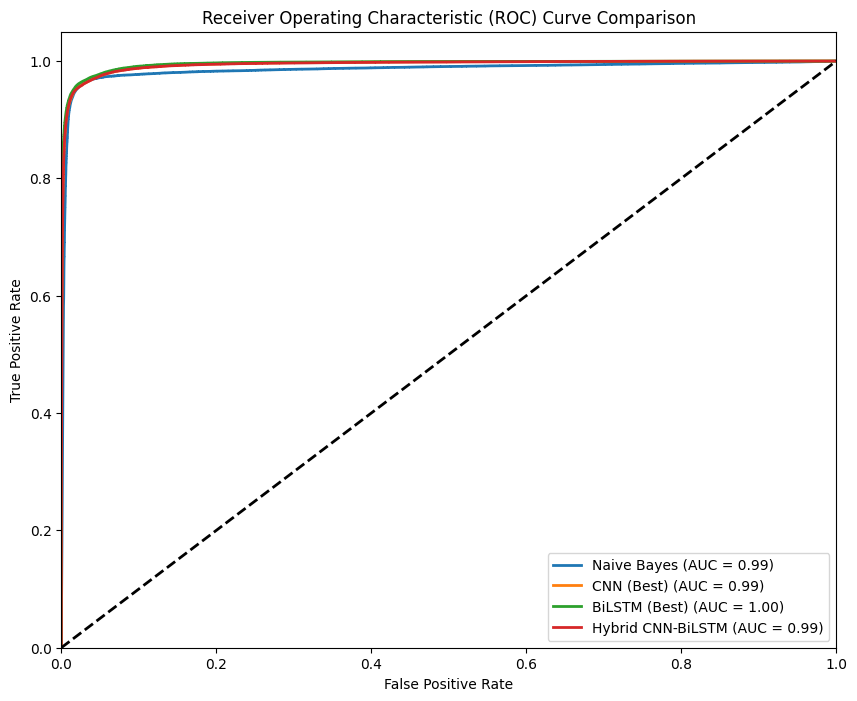

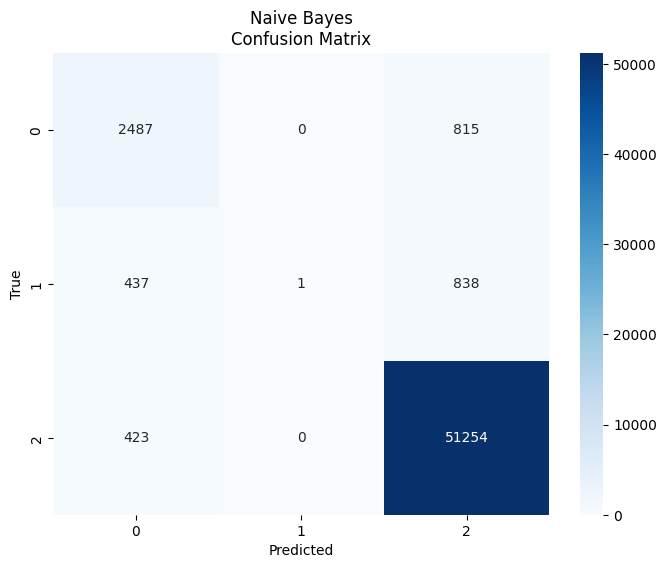

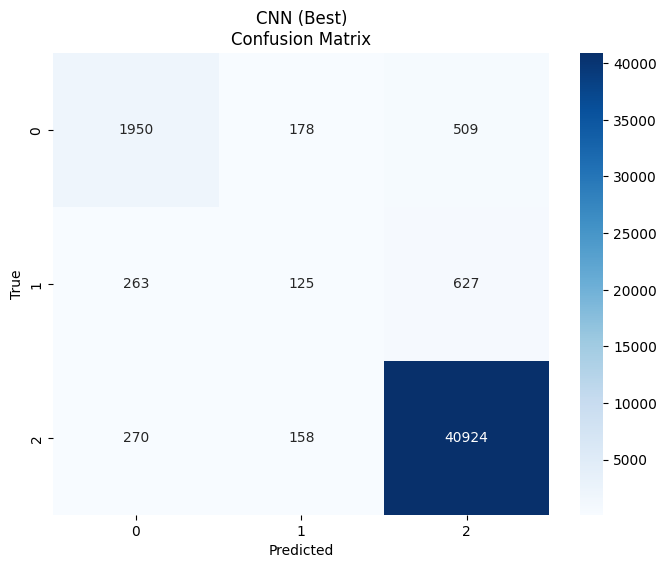

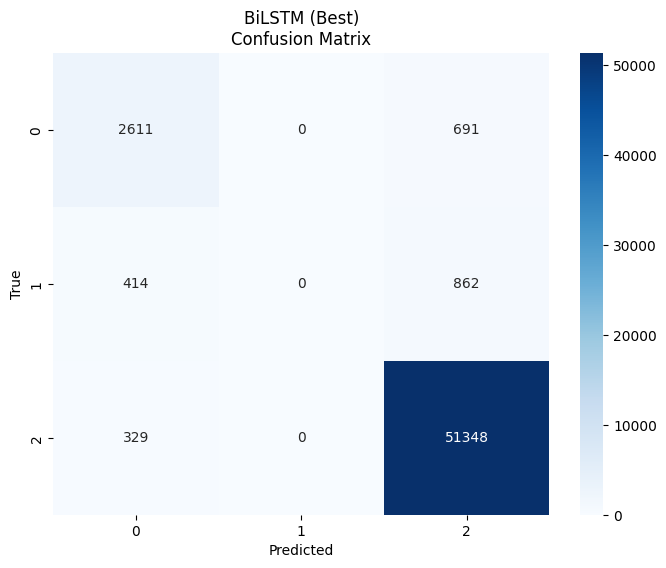

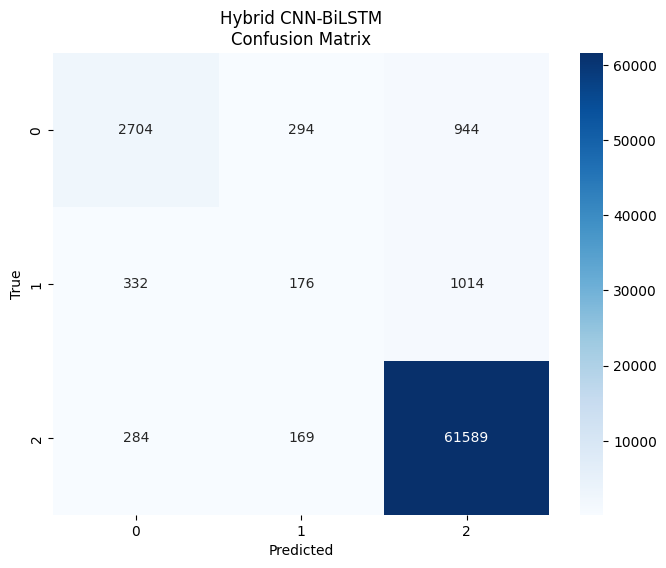

<Figure size 640x480 with 0 Axes>

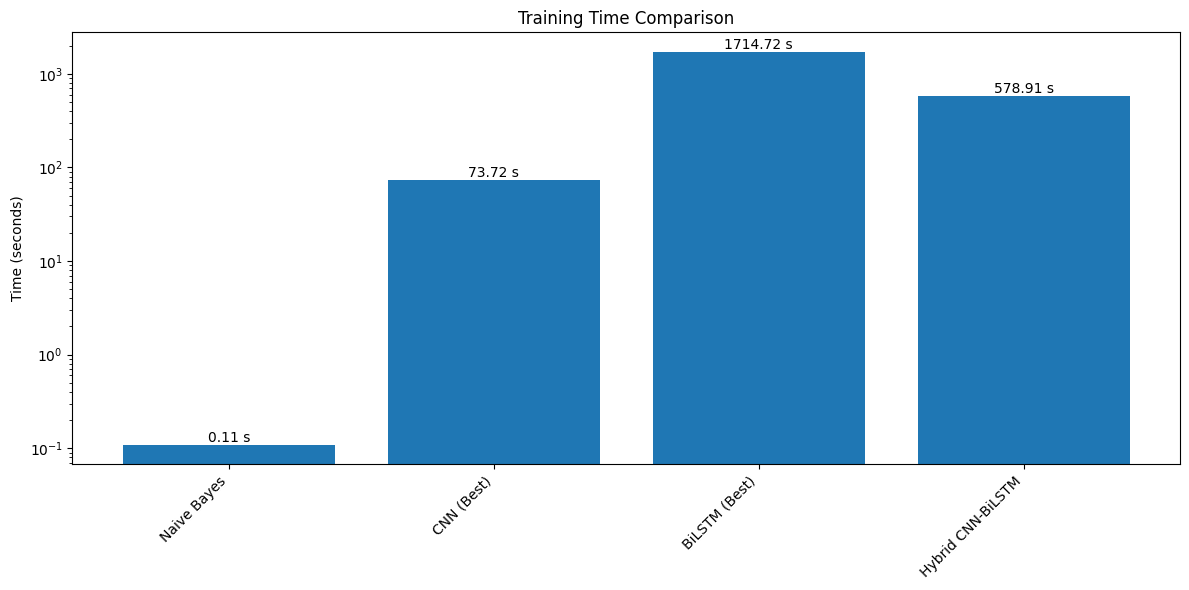

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


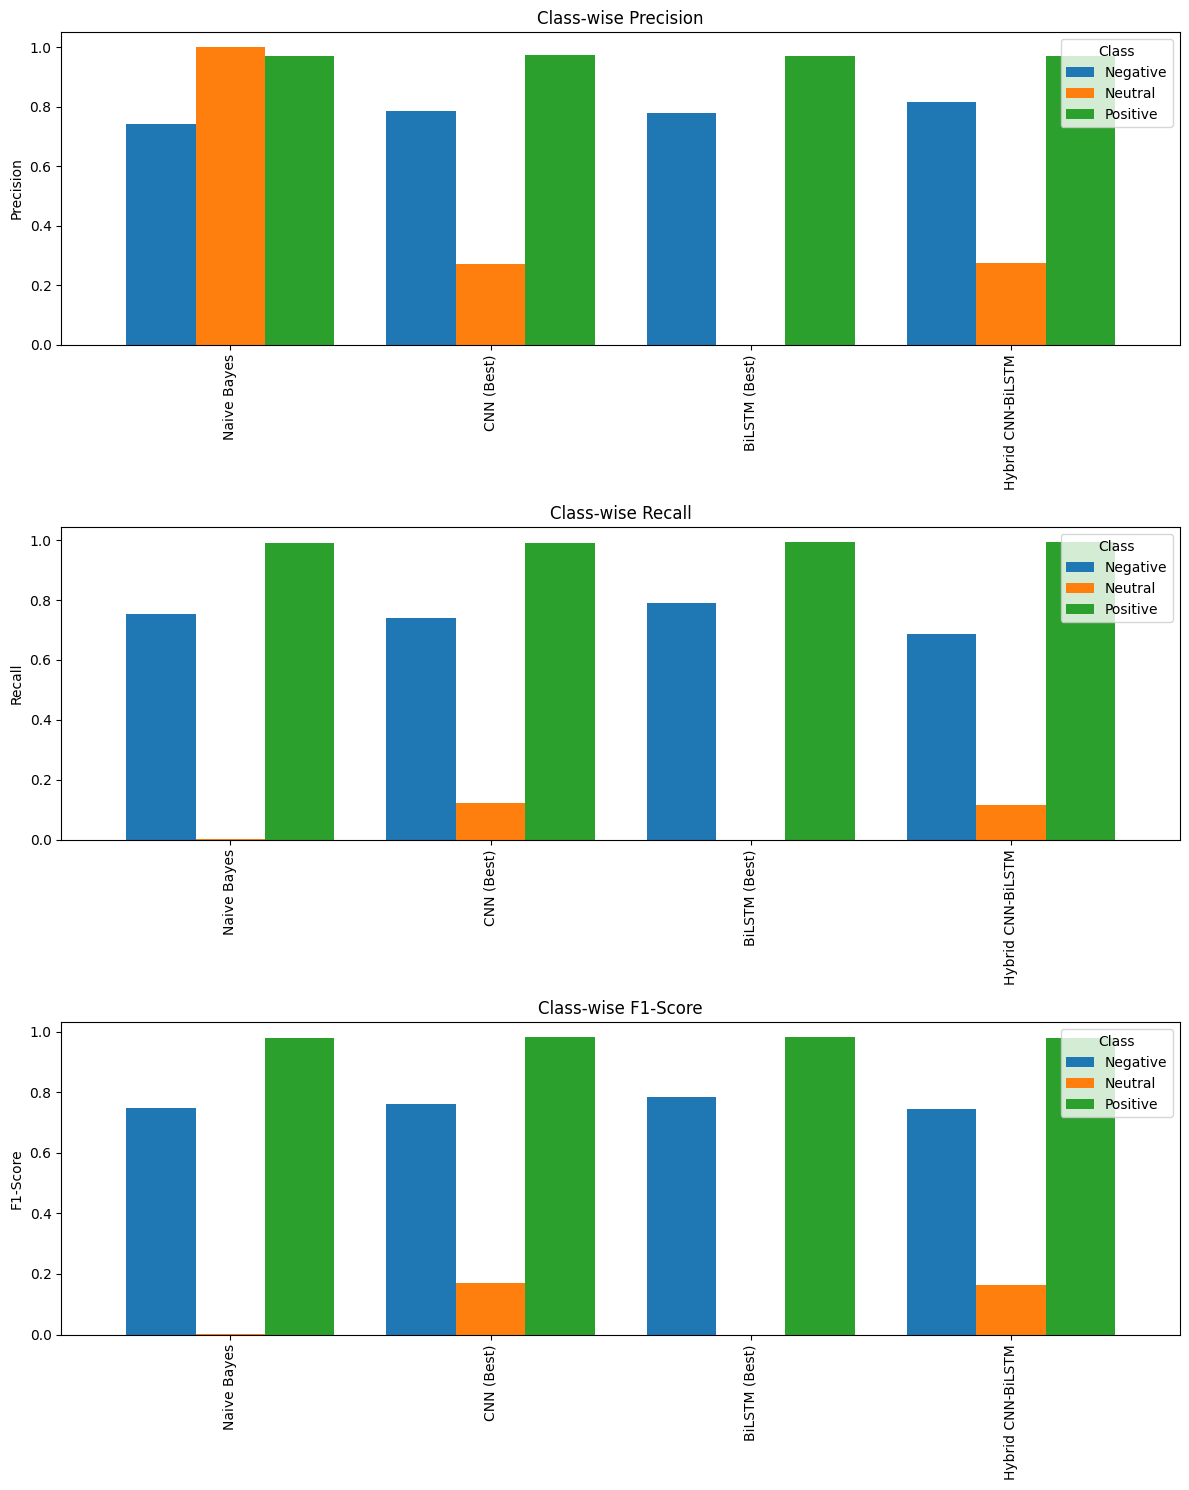

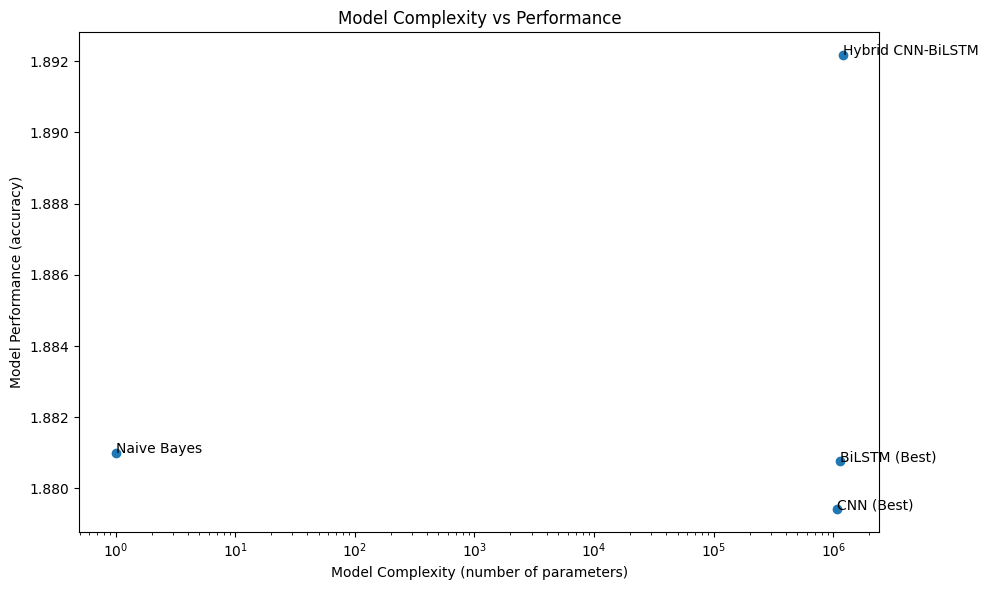


Test Set Sizes:
Naive Bayes: 56255
CNN (Best): 45004
BiLSTM (Best): 56255
Hybrid CNN-BiLSTM: 67506

Class Distribution in Test Sets:

Naive Bayes:
Class 0: 3302 (5.87%)
Class 1: 1276 (2.27%)
Class 2: 51677 (91.86%)

CNN (Best):
Class 0: 2637 (5.86%)
Class 1: 1015 (2.26%)
Class 2: 41352 (91.89%)

BiLSTM (Best):
Class 0: 3302 (5.87%)
Class 1: 1276 (2.27%)
Class 2: 51677 (91.86%)

Hybrid CNN-BiLSTM:
Class 0: 3942 (5.84%)
Class 1: 1522 (2.25%)
Class 2: 62042 (91.91%)

Model Complexity and Configuration Comparison:
Naive Bayes parameters: N/A (not applicable)
CNN parameters: 1065451 (Embedding dim: 100)
BiLSTM parameters: 1126379 (LSTM units: 64)
Hybrid parameters: 1204843 (Embedding dim: 100, LSTM units: 64)


In [21]:
def compare_all_models(models_data):
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC', 'Training Time']

    results = {}
    for model_name, data in models_data.items():
        y_true = data['y_true']
        y_pred = data['y_pred']
        y_pred_proba = data['y_pred_proba']

        # Handle multiclass ROC AUC
        classes = np.unique(y_true)
        y_true_bin = label_binarize(y_true, classes=classes)
        if len(classes) > 2:
            auc_score = roc_auc_score(y_true_bin, y_pred_proba, multi_class='ovr', average='weighted')
        else:
            auc_score = roc_auc_score(y_true, y_pred_proba[:, 1])

        # Handle training time
        train_time = data.get('train_time', np.nan)
        train_time_str = f"{train_time:.2f} s"

        results[model_name] = [
            accuracy_score(y_true, y_pred),
            precision_score(y_true, y_pred, average='weighted'),
            recall_score(y_true, y_pred, average='weighted'),
            f1_score(y_true, y_pred, average='weighted'),
            auc_score,
            train_time_str
        ]

    # Convert results to DataFrame
    results_df = pd.DataFrame.from_dict(results, orient='index', columns=metrics)

    # Plotting performance metrics
    fig, ax = plt.subplots(figsize=(14, 8))
    results_df.iloc[:, :-1].plot(kind='bar', ax=ax)
    ax.set_ylabel('Scores')
    ax.set_title('Model Comparison')
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()

    # Print results
    print("\nModel Comparison:")
    print(results_df.to_string())

    # Determine best model for each metric
    best_models = results_df.iloc[:, :-1].idxmax()  # Exclude 'Training Time' from best model calculation
    print("\nBest Models:")
    for metric, model in best_models.items():
        print(f"Best {metric}: {model} ({results_df.loc[model, metric]})")

    # Print model configurations
    print("\nModel Configurations:")
    for model_name, data in models_data.items():
        print(f"\n{model_name}:")
        if 'embedding_dim' in data:
            print(f"  Embedding Dimension: {data['embedding_dim']}")
        if 'lstm_units' in data:
            print(f"  LSTM Units: {data['lstm_units']}")

    # Plot ROC curves for all models
    plt.figure(figsize=(10, 8))
    for model_name, data in models_data.items():
        y_true = data['y_true']
        y_pred_proba = data['y_pred_proba']

        # Binarize the output
        y_test_bin = label_binarize(y_true, classes=np.unique(y_true))
        n_classes = y_test_bin.shape[1]

        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        plt.plot(fpr["micro"], tpr["micro"],
                 label=f'{model_name} (AUC = {roc_auc["micro"]:.2f})',
                 linewidth=2)

    plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve Comparison')
    plt.legend(loc="lower right")
    plt.show()

    return results_df

def plot_confusion_matrices(models_data):
    for model_name, data in models_data.items():
        plt.figure(figsize=(8, 6))
        cm = confusion_matrix(data['y_true'], data['y_pred'])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'{model_name}\nConfusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

    plt.tight_layout()
    plt.show()

def plot_training_times(models_data):
    model_names = list(models_data.keys())
    times = [data['train_time'] for model, data in models_data.items()]

    plt.figure(figsize=(12, 6))
    bars = plt.bar(model_names, times)
    plt.title('Training Time Comparison')
    plt.ylabel('Time (seconds)')
    plt.yscale('log')  # Using log scale due to large differences
    plt.xticks(rotation=45, ha='right')

    # Annotate bars with time and units
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height,
                     f'{height:.2f} s',
                     ha='center', va='bottom', rotation=0)

    plt.tight_layout()
    plt.show()

def plot_class_performance(models_data):
    class_names = ['Negative', 'Neutral', 'Positive']  # Adjust based on your classes
    metrics = ['Precision', 'Recall', 'F1-Score']

    fig, axes = plt.subplots(len(metrics), 1, figsize=(12, 5*len(metrics)))
    for i, metric in enumerate(metrics):
        data = []
        for model_name, model_data in models_data.items():
            scores = precision_recall_fscore_support(model_data['y_true'], model_data['y_pred'], average=None)[i]
            data.append(scores)

        df = pd.DataFrame(data, columns=class_names, index=models_data.keys())
        df.plot(kind='bar', ax=axes[i], width=0.8)
        axes[i].set_title(f'Class-wise {metric}')
        axes[i].set_ylabel(metric)
        axes[i].legend(title='Class')

    plt.tight_layout()
    plt.show()

def plot_complexity_vs_performance(models_data):
    complexities = {
        'Naive Bayes': 1,  # placeholder value
        'CNN (Best)': cnn_model.count_params(),
        'BiLSTM (Best)': bilstm_model.count_params(),
        'Hybrid CNN-BiLSTM': hybrid_model.count_params()
    }
    performances = {model: data['y_pred'].mean() for model, data in models_data.items()}

    plt.figure(figsize=(10, 6))
    plt.scatter(complexities.values(), performances.values())
    for model, complexity in complexities.items():
        plt.annotate(model, (complexity, performances[model]))
    plt.xscale('log')
    plt.xlabel('Model Complexity (number of parameters)')
    plt.ylabel('Model Performance (accuracy)')
    plt.title('Model Complexity vs Performance')
    plt.tight_layout()
    plt.show()

# Prepare data for comparison
models_data = {
    'Naive Bayes': nb_results_dict,
    'CNN (Best)': cnn_results_dict,
    'BiLSTM (Best)': bilstm_results_dict,
    'Hybrid CNN-BiLSTM': hybrid_results_dict
}

# Run comparison
results_df = compare_all_models(models_data)
plot_confusion_matrices(models_data)
plot_training_times(models_data)
plot_class_performance(models_data)
plot_complexity_vs_performance(models_data)

# Additional analysis
print("\nTest Set Sizes:")
for model, data in models_data.items():
    print(f"{model}: {len(data['y_true'])}")

print("\nClass Distribution in Test Sets:")
for model, data in models_data.items():
    y_test = data['y_true']
    unique, counts = np.unique(y_test, return_counts=True)
    print(f"\n{model}:")
    for label, count in zip(unique, counts):
        print(f"Class {label}: {count} ({count/len(y_test):.2%})")



# Model complexity and configuration comparison
print("\nModel Complexity and Configuration Comparison:")
print(f"Naive Bayes parameters: N/A (not applicable)")
print(f"CNN parameters: {cnn_model.count_params()} (Embedding dim: {models_data['CNN (Best)']['embedding_dim']})")
print(f"BiLSTM parameters: {bilstm_model.count_params()} (LSTM units: {models_data['BiLSTM (Best)']['lstm_units']})")
print(f"Hybrid parameters: {hybrid_model.count_params()} (Embedding dim: {models_data['Hybrid CNN-BiLSTM']['embedding_dim']}, LSTM units: {models_data['Hybrid CNN-BiLSTM']['lstm_units']})")

In [22]:
import pickle
# Save models and results
def save_models_and_results(models_dict, filename_prefix):
    # Save each model separately (because they might be large)
    for model_name, results in models_dict.items():
        # Save the model
        model = results['model']
        model.save(f'{filename_prefix}_{model_name.lower()}_model.keras')

        # Create a copy of results without the model
        results_copy = results.copy()
        results_copy.pop('model')  # Remove model from dictionary before saving

        # Save other results
        with open(f'{filename_prefix}_{model_name.lower()}_results.pkl', 'wb') as f:
            pickle.dump(results_copy, f)




models_to_save_dict = {
    'CNN (Best)': cnn_results_dict,
    'BiLSTM (Best)': bilstm_results_dict,
    'Hybrid CNN-BiLSTM': hybrid_results_dict
}

# Modified save function for Naive Bayes
import joblib

# Save Naive Bayes model
joblib.dump(nb_results_dict['model'], 'nb_model_tp.joblib')

save_models_and_results(models_to_save_dict, 'sentiment_analysis_tp')

In [ ]:
# To load later:
# To load the models and results back
def load_models_and_results(models_list, filename_prefix):
    from keras_core.models import load_model

    loaded_models = {}
    for model_name in models_list:
        # Load the model
        model = load_model(f'{filename_prefix}_{model_name.lower()}_model')

        # Load the results
        with open(f'{filename_prefix}_{model_name.lower()}_results.pkl', 'rb') as f:
            results = pickle.load(f)

        # Combine model and results
        results['model'] = model
        loaded_models[model_name] = results

    return loaded_models

models_list = ['CNN (Best)', 'BiLSTM (Best)', 'Hybrid CNN-BiLSTM']
loaded_models = load_models_and_results(models_list, 'sentiment_analysis_tp')
nb_results_dict = joblib.load('nb_model_tp.joblib')